In [8]:
import sys
sys.path.append("../script/")

import Functions
from Engine import Engine


from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import importlib
from time import time
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import numpy as np
import pandas as pd
from time import time

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

# data

In [10]:
from sklearn.utils import shuffle

In [13]:
df = pd.read_csv("../data/covtype.data",delimiter=',')
X = df.iloc[:,:-1].to_numpy().astype("float")
y = df.iloc[:,-1].to_numpy().astype("int")  - 1

X,y = shuffle(X,y)
X = X[:len(X)//100]
y = y[:len(y)//100]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,stratify=y)
y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

# model

In [12]:
def to_one_hot(y,yt):
    le = LabelEncoder()
    ohe = OneHotEncoder()
    y_train = le.fit_transform(y)
    y_one_hot = ohe.fit_transform(y_train.reshape(-1,1))
    
    y_test = le.transform(yt)
    yt_one_hot = ohe.transform(y_test.reshape(-1,1))
    
    return y_train,y_test,y_one_hot,yt_one_hot

def initial(y_one_hot):
    init_log_odds = np.sum(y_one_hot,axis=0)/y_one_hot.shape[0]
    
    init_p = np.exp(init_log_odds)
    init_p = init_p/(1+init_p)

    return init_log_odds,init_p

def initial_first_bin(init_log_odds,init_p,X):
    log_odds = np.repeat(init_log_odds,X.shape[0],0)
    p = np.repeat(init_p,X.shape[0],0)
    
    return log_odds,p
    
def update_log_p(grads,log_odds,p,learning_rate):
    log_odds_1 = log_odds + learning_rate * grads
    
    p_1 = np.exp(log_odds_1,where=log_odds_1 < 16,out=np.zeros(log_odds_1.shape)+16)
    p_1 = np.divide(p_1,(1+p_1),where=p_1 < 16,out=np.ones(p_1.shape))
    
    # p_1 = np.exp(log_odds_1)
    # p_1 = np.divide(p_1,(1+p_1))

    return log_odds_1,p_1

def predict(X,init_log_odds,init_p,learning_rate,stack):
    log_odds,p = initial_first_bin(init_log_odds,init_p,X)

    for node in stack:
        grads = node.predict_grad(X)
        
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    return p

In [8]:
train_acc = []
test_acc = []

stack = []

init_log_odds,init_p = initial(y_train_one_hot)
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)
test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

learning_rate = 0.3
bins = 10
lam = 10
stack = []
losses = []
num_features = X_train.shape[1]

max_depth = 3

total_size = 10
elite_size = 10

eg = Engine(Functions.simple_opset,X_train,y_train,y_train_one_hot,learning_rate,bins,max_depth,lam)
eg.initialize_nodes(log_odds,p)
origin_features = eg.nodes.copy()
origin_losses = eg.losses.copy()
stack.extend(eg.nodes)
losses.extend(origin_losses)

l = np.sort(losses).astype(np.float64)
difference = l[1:] - l[:-1]
difference[difference==0] = 2**16

tolerance = min(difference) * 10000
print("torlerance:",tolerance)

for i in range(3000):
    for j in range(3):
        eg.evolve(total_size,elite_size,log_odds,p,tolerance=tolerance,verbose=0)
    winner = eg.nodes
    stack,losses = eg.adding_unique_node(stack,losses,winner,tolerance=tolerance)
    eg.nodes = origin_features.copy()
    eg.losses = origin_losses.copy()
    print(len(stack),sum([n.numNode for n in stack]),i)
    # if len(stack) > 8000:
    #         break

torlerance: 0.01695445710936383
57 63 0
58 66 1
60 72 2
65 87 3
65 87 4
67 93 5
67 93 6
67 93 7
69 99 8
70 102 9
70 102 10
73 117 11
73 117 12
74 120 13
74 120 14
74 120 15
76 126 16
77 131 17
78 134 18
78 134 19
78 134 20
79 137 21
79 137 22
81 145 23
82 148 24
83 151 25
85 157 26
85 157 27
85 157 28
87 163 29
88 166 30
88 166 31
88 166 32
89 169 33
90 172 34
92 180 35
92 180 36
93 183 37
93 183 38
93 183 39
93 183 40
93 183 41
93 183 42
95 189 43
96 192 44
95 183 45
95 183 46
95 183 47
95 183 48
96 186 49
96 186 50
97 189 51
99 195 52
101 201 53
102 204 54
102 204 55
102 204 56
103 207 57
105 215 58
105 215 59
105 215 60
106 220 61
106 220 62
106 220 63
106 220 64
106 220 65


KeyboardInterrupt: 

930.2358684191181 1185.70291935556 1185.689840654042


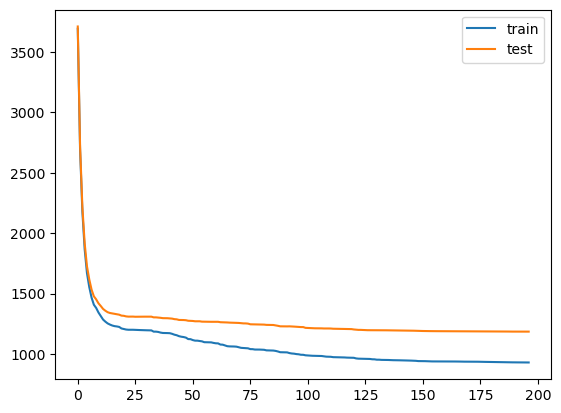

782.1621986716959 1165.708931004779 1165.6463978326005


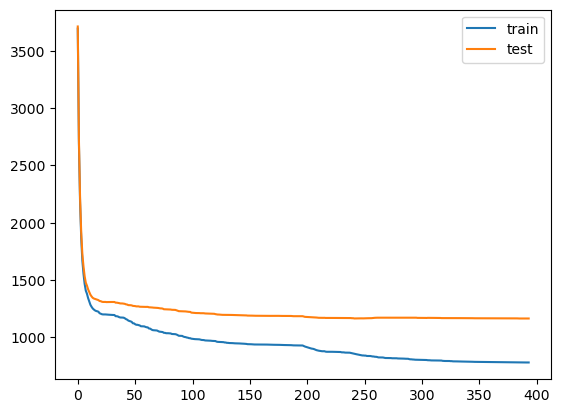

695.3979348557759 1173.8672297994524 1163.4818788273578


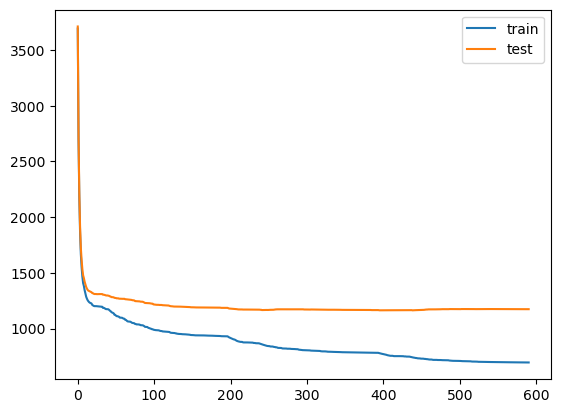

634.7279464731258 1188.4643472218056 1163.4818788273578


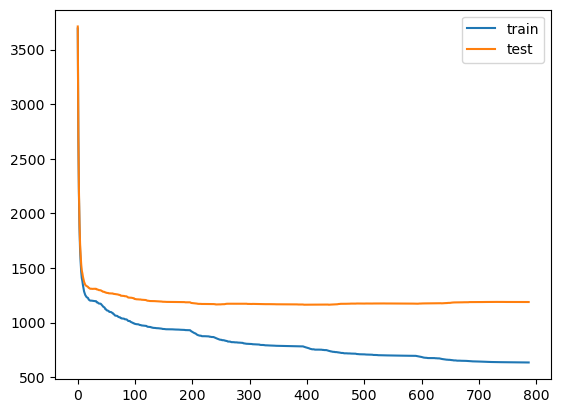

588.9007704233459 1204.6114901269905 1163.4818788273578


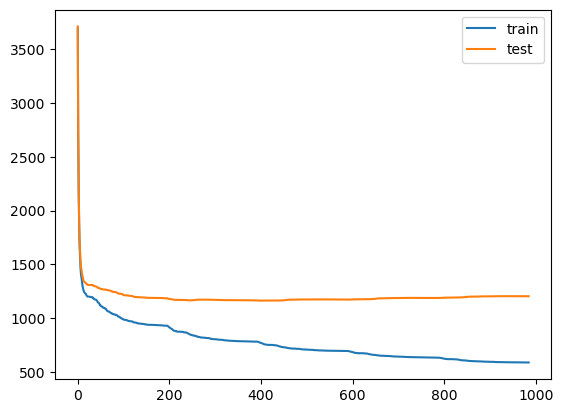

552.498207641674 1220.9824820612416 1163.4818788273578


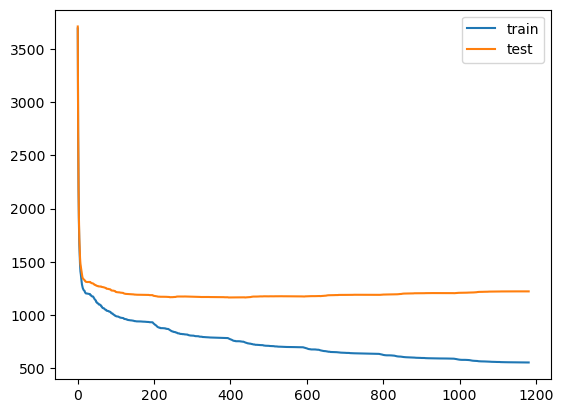

522.8667141079131 1237.1062357291307 1163.4818788273578


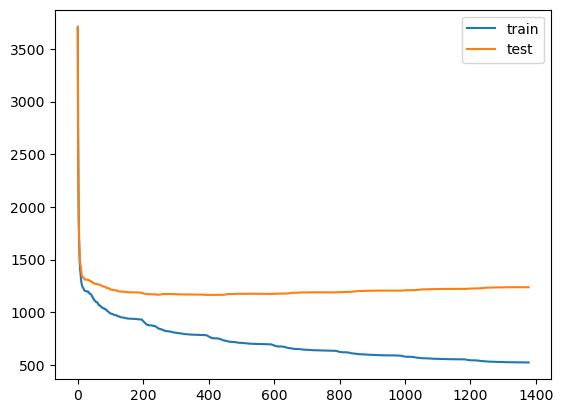

497.9349328972436 1251.7308542272513 1163.4818788273578


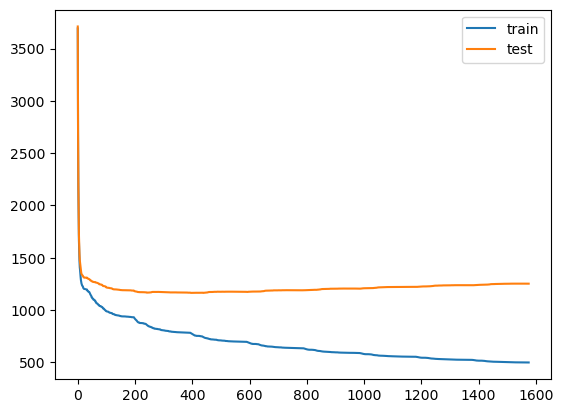

476.66998992341365 1265.3498373414134 1163.4818788273578


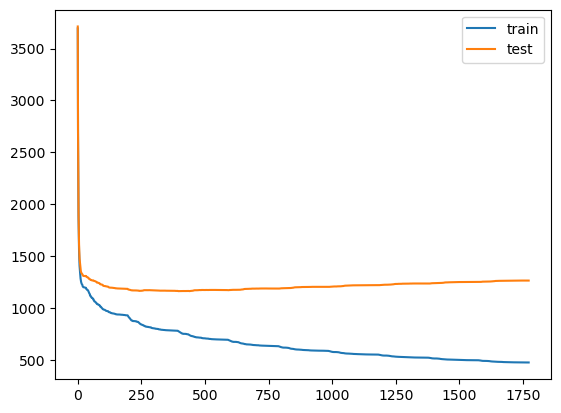

458.2580826337128 1277.995953963451 1163.4818788273578


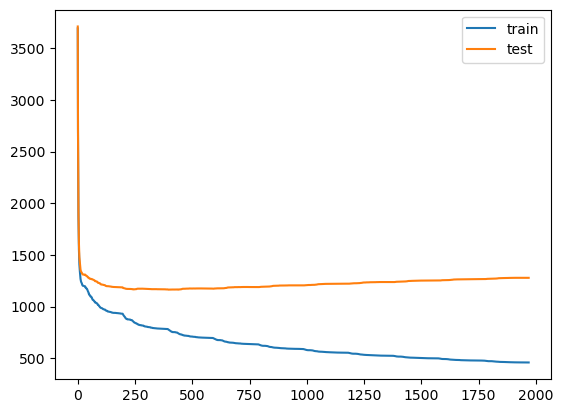

In [7]:
y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

lam = 5
fits = [i.estimator.loss for i in stack]
a = [stack[i] for i in np.argsort(fits)]

log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)
test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

# a = get_order(a,y_train_one_hot,log_odds,p,previous_sse=np.sum(np.power(y_train_one_hot - p,2)))

train_acc = []
test_acc = []

train_sse = []
test_sse = []


counts = []

for _ in range(10):
    score = []
    
    for i,node in enumerate(a):
        node.estimator.lam = lam + 3*node.numNode
        grads = node.estimator.set_grads_bin(y_train_one_hot-p,p)
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)

        test_grads = node.predict_grad(X_test)
        test_log_odds,test_p = update_log_p(test_grads,test_log_odds,test_p,learning_rate)


        train_sse.append(np.sum(np.power(y_train_one_hot - p,2)))
        test_sse.append(np.sum(np.power(y_test_one_hot - test_p,2)))
        # score.append(previous_sse - train_sse[-1])
        # previous_sse = train_sse[-1]


        # pred = np.argmax(p,axis=1)
        # train_acc.append(accuracy_score(pred,y_train))
        # test_pred = np.argmax(test_p,axis=1)
        # test_acc.append(accuracy_score(test_pred,y_test))
    
    # a = [a[i] for i in np.argsort(score)[::-1]]

    # plt.plot(train_acc)
    # plt.plot(test_acc)
    # print(train_acc[-1],test_acc[-1],max(test_acc))

    plt.plot(train_sse)
    plt.plot(test_sse)
    print(train_sse[-1],test_sse[-1],min(test_sse))

    plt.legend(["train","test"])
    plt.show()
    

Node: 284 train sse: 921.1508214010346 test sse: 1132.554073469722


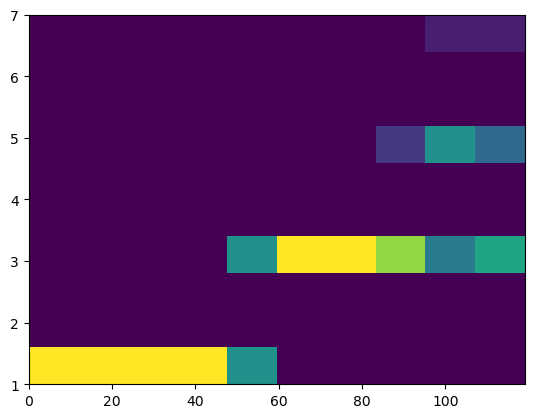

              precision    recall  f1-score   support

           0    0.75141   0.75071   0.75106      1063
           1    0.78567   0.83734   0.81068      1414
           2    0.84000   0.81290   0.82623       155
           3    1.00000   0.60000   0.75000        10
           4    0.90909   0.21739   0.35088        46
           5    0.79787   0.70755   0.75000       106
           6    0.86667   0.58559   0.69892       111

    accuracy                        0.77935      2905
   macro avg    0.85010   0.64450   0.70540      2905
weighted avg    0.78226   0.77935   0.77572      2905

              precision    recall  f1-score   support

           0    0.71591   0.71053   0.71321      1064
           1    0.75463   0.80750   0.78017      1413
           2    0.63816   0.62987   0.63399       154
           3    0.50000   0.27273   0.35294        11
           4    0.60000   0.06383   0.11538        47
           5    0.50602   0.40000   0.44681       105
           6    0.69231 

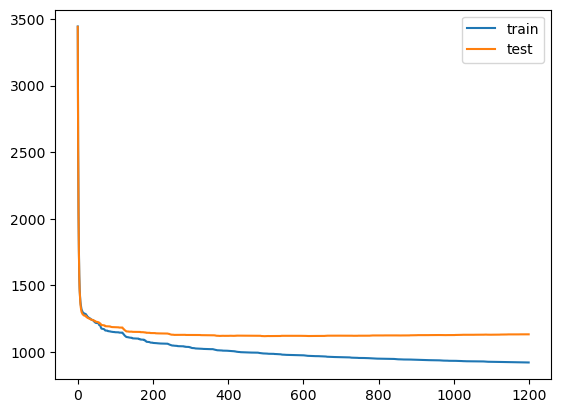

In [22]:
print("Node:",sum([n.numNode for n in stack]),"train sse:",train_sse[-1],"test sse:",test_sse[-1])
plt.hist2d([i for i in range(len(stack))],[n.numNode for n in stack])
plt.show()
plt.plot(train_sse)
plt.plot(test_sse)
plt.legend(["train","test"])    
print(classification_report(y_train,np.argmax(p,axis=1),digits=5))
print(classification_report(y_test,np.argmax(test_p,axis=1),digits=5))

In [180]:
sum([n.numNode for n in stack])

18382

              precision    recall  f1-score   support

           0    0.87753   0.83768   0.85714      1035
           1    0.85976   0.91620   0.88709      1432
           2    0.91878   0.96791   0.94271       187
           3    1.00000   1.00000   1.00000        12
           4    1.00000   0.27907   0.43636        43
           5    0.93243   0.75000   0.83133        92
           6    0.95833   0.88462   0.92000       104

    accuracy                        0.87608      2905
   macro avg    0.93526   0.80507   0.83923      2905
weighted avg    0.87838   0.87608   0.87321      2905

              precision    recall  f1-score   support

           0    0.73221   0.71525   0.72363      1036
           1    0.76194   0.81355   0.78690      1432
           2    0.69091   0.81283   0.74693       187
           3    1.00000   0.30769   0.47059        13
           4    0.66667   0.14286   0.23529        42
           5    0.56000   0.30435   0.39437        92
           6    0.76543 

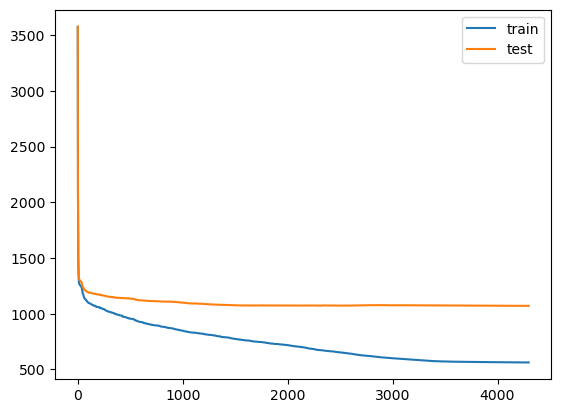

In [181]:
plt.plot(train_sse)
plt.plot(test_sse)
plt.legend(["train","test"])    
print(classification_report(y_train,np.argmax(p,axis=1),digits=5))
print(classification_report(y_test,np.argmax(test_p,axis=1),digits=5))

# Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)

print(classification_report(y_train,clf.predict(X_train)))
print(classification_report(y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1073
           1       1.00      1.00      1.00      1399
           2       1.00      1.00      1.00       176
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        51
           5       1.00      1.00      1.00        94
           6       1.00      1.00      1.00       102

    accuracy                           1.00      2905
   macro avg       1.00      1.00      1.00      2905
weighted avg       1.00      1.00      1.00      2905

              precision    recall  f1-score   support

           0       0.66      0.63      0.64      1073
           1       0.70      0.72      0.71      1400
           2       0.63      0.61      0.62       176
           3       0.20      0.18      0.19        11
           4       0.14      0.16      0.15        51
           5       0.36      0.41      0.38        93
           6       0.45 

# XGBoost

In [6]:
import xgboost


In [15]:
xgb = xgboost.XGBClassifier(n_estimators=10)
xgb.fit(X_train,y_train)

print(classification_report(y_train,xgb.predict(X_train),digits=5))
print(classification_report(y_test,xgb.predict(X_test),digits=5))
print("train:",np.sum(np.power(y_train_one_hot - xgb.predict_proba(X_train),2)))
print("test:",np.sum(np.power(y_test_one_hot - xgb.predict_proba(X_test),2)))

import json

def item_generator(json_input, lookup_key):
    if isinstance(json_input, dict):
        for k, v in json_input.items():
            if k == lookup_key:
                yield v
            else:
                yield from item_generator(v, lookup_key)
    elif isinstance(json_input, list):
        for item in json_input:
            yield from item_generator(item, lookup_key)

def tree_depth(json_text):
    json_input = json.loads(json_text)
    depths = list(item_generator(json_input, 'depth'))
    return max(depths) + 1 if len(depths) != 0 else 1


booster = xgb.get_booster()

tree_df = booster.trees_to_dataframe()
depths = [tree_depth(x) for x in booster.get_dump(dump_format = "json")]
len(depths),np.average(depths),len(tree_df)

              precision    recall  f1-score   support

           0    0.83930   0.81180   0.82532      1068
           1    0.83984   0.89682   0.86740      1415
           2    0.92398   0.93491   0.92941       169
           3    1.00000   0.86667   0.92857        15
           4    0.96154   0.56818   0.71429        44
           5    0.98333   0.73750   0.84286        80
           6    0.98901   0.78947   0.87805       114

    accuracy                        0.85404      2905
   macro avg    0.93386   0.80076   0.85513      2905
weighted avg    0.85701   0.85404   0.85327      2905

              precision    recall  f1-score   support

           0    0.73040   0.71603   0.72314      1067
           1    0.75456   0.81966   0.78576      1414
           2    0.68852   0.74556   0.71591       169
           3    0.40000   0.13333   0.20000        15
           4    0.50000   0.09091   0.15385        44
           5    0.53333   0.39506   0.45390        81
           6    0.82090 

(70, 5.914285714285715, 3090)

In [21]:
xgb = xgboost.XGBClassifier()
xgb.fit(X_train,y_train)

print(classification_report(y_train,xgb.predict(X_train),digits=5))
print(classification_report(y_test,xgb.predict(X_test),digits=5))
print("train:",np.sum(np.power(y_train_one_hot - xgb.predict_proba(X_train),2)))
print("test:",np.sum(np.power(y_test_one_hot - xgb.predict_proba(X_test),2)))

import json

def item_generator(json_input, lookup_key):
    if isinstance(json_input, dict):
        for k, v in json_input.items():
            if k == lookup_key:
                yield v
            else:
                yield from item_generator(v, lookup_key)
    elif isinstance(json_input, list):
        for item in json_input:
            yield from item_generator(item, lookup_key)

def tree_depth(json_text):
    json_input = json.loads(json_text)
    depths = list(item_generator(json_input, 'depth'))
    return max(depths) + 1 if len(depths) != 0 else 1


booster = xgb.get_booster()

tree_df = booster.trees_to_dataframe()
depths = [tree_depth(x) for x in booster.get_dump(dump_format = "json")]
len(depths),np.average(depths),len(tree_df)

              precision    recall  f1-score   support

           0    0.99907   1.00000   0.99953      1073
           1    1.00000   0.99929   0.99964      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        0.99966      2905
   macro avg    0.99987   0.99990   0.99988      2905
weighted avg    0.99966   0.99966   0.99966      2905

              precision    recall  f1-score   support

           0    0.75288   0.72973   0.74113      1073
           1    0.76918   0.83071   0.79876      1400
           2    0.73913   0.77273   0.75556       176
           3    0.57143   0.36364   0.44444        11
           4    0.42857   0.11765   0.18462        51
           5    0.57353   0.41935   0.48447        93
           6    0.72500 

(700, 5.345714285714286, 22542)

# GDBT

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

In [17]:
clf = GradientBoostingClassifier(n_estimators=10)
clf.fit(X_train,y_train)

print(classification_report(y_train,clf.predict(X_train),digits=5))
print(classification_report(y_test,clf.predict(X_test),digits=5))
print("train:",np.sum(np.power(y_train_one_hot - clf.predict_proba(X_train),2)))
print("test:",np.sum(np.power(y_test_one_hot - clf.predict_proba(X_test),2)))

len(clf.estimators_)*len(clf.classes_),sum([ est.tree_.node_count for ests in clf.estimators_ for est in ests])

              precision    recall  f1-score   support

           0    0.72404   0.70506   0.71442      1068
           1    0.75016   0.83604   0.79078      1415
           2    0.79290   0.79290   0.79290       169
           3    1.00000   0.93333   0.96552        15
           4    0.91667   0.25000   0.39286        44
           5    0.82353   0.35000   0.49123        80
           6    0.86441   0.44737   0.58960       114

    accuracy                        0.74836      2905
   macro avg    0.83881   0.61639   0.67676      2905
weighted avg    0.75336   0.74836   0.74156      2905

              precision    recall  f1-score   support

           0    0.68597   0.65511   0.67018      1067
           1    0.71160   0.80269   0.75440      1414
           2    0.66667   0.61538   0.64000       169
           3    0.53846   0.46667   0.50000        15
           4    0.20000   0.04545   0.07407        44
           5    0.41379   0.29630   0.34532        81
           6    0.85185 

(70, 1034)

In [23]:
clf = GradientBoostingClassifier(max_depth=5,n_estimators=100)
clf.fit(X_train,y_train)

print(classification_report(y_train,clf.predict(X_train),digits=5))
print(classification_report(y_test,clf.predict(X_test),digits=5))
print("train:",np.sum(np.power(y_train_one_hot - clf.predict_proba(X_train),2)))
print("test:",np.sum(np.power(y_test_one_hot - clf.predict_proba(X_test),2)))

len(clf.estimators_)*len(clf.classes_),sum([ est.tree_.node_count for ests in clf.estimators_ for est in ests])

              precision    recall  f1-score   support

           0    0.98581   0.97111   0.97840      1073
           1    0.97809   0.98928   0.98365      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        0.98417      2905
   macro avg    0.99484   0.99434   0.99458      2905
weighted avg    0.98421   0.98417   0.98415      2905

              precision    recall  f1-score   support

           0    0.74049   0.70736   0.72355      1073
           1    0.75892   0.82071   0.78861      1400
           2    0.72826   0.76136   0.74444       176
           3    0.46154   0.54545   0.50000        11
           4    0.23529   0.07843   0.11765        51
           5    0.61538   0.34409   0.44138        93
           6    0.63000 

(700, 35600)

# batch

torlerance: 0.057328068063799975
55 261 255
1174.834653724764 1237.2115862855242 1236.88247286063


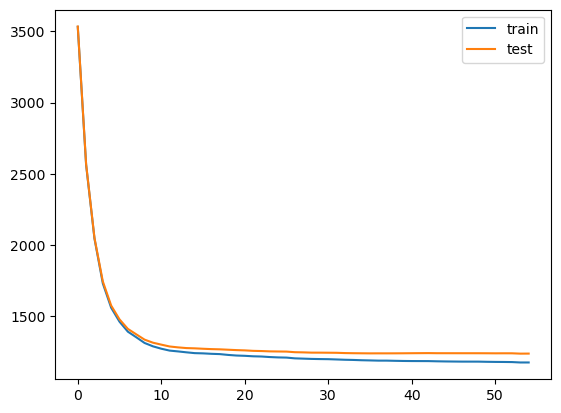

Node: 0 train sse: 1174.834653724764 test sse: 1237.2115862855242


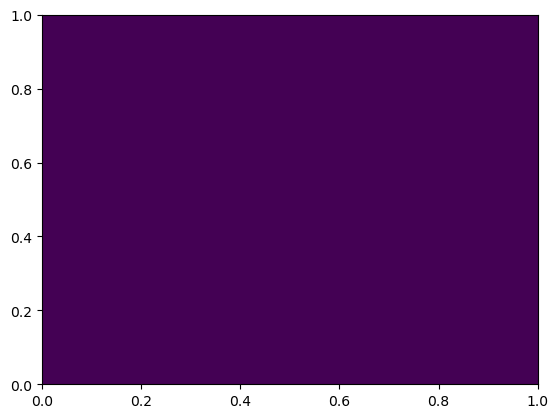

              precision    recall  f1-score   support

           0    0.68435   0.69711   0.69067      1073
           1    0.72142   0.78485   0.75180      1399
           2    0.71220   0.82955   0.76640       176
           3    0.00000   0.00000   0.00000        10
           4    0.00000   0.00000   0.00000        51
           5    0.67742   0.22340   0.33600        94
           6    0.83333   0.44118   0.57692       102

    accuracy                        0.70843      2905
   macro avg    0.51839   0.42515   0.44597      2905
weighted avg    0.69453   0.70843   0.69472      2905

              precision    recall  f1-score   support

           0    0.68865   0.66170   0.67490      1073
           1    0.70917   0.80643   0.75468      1400
           2    0.66146   0.72159   0.69022       176
           3    0.00000   0.00000   0.00000        11
           4    0.00000   0.00000   0.00000        51
           5    0.42857   0.12903   0.19835        93
           6    0.64516 

c:\Users\zhouz\anaconda3\envs\BStackGP\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zhouz\anaconda3\envs\BStackGP\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zhouz\anaconda3\envs\BStackGP\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zhou

torlerance: 0.06640857505568754
28 108 255
1130.4984221746734 1214.5552416037235 1214.3233189211276


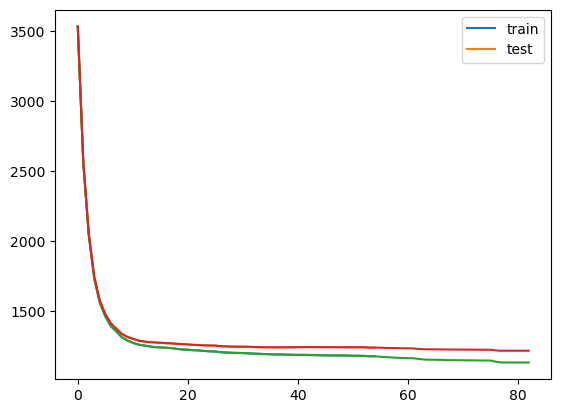

Node: 261 train sse: 1130.4984221746734 test sse: 1214.5552416037235


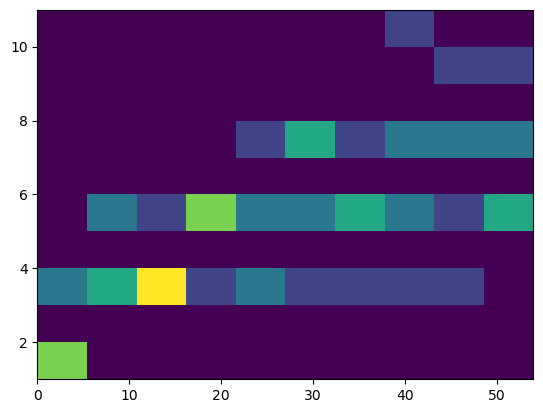

              precision    recall  f1-score   support

           0    0.71092   0.70363   0.70726      1073
           1    0.73399   0.80272   0.76681      1399
           2    0.71090   0.85227   0.77519       176
           3    0.00000   0.00000   0.00000        10
           4    0.00000   0.00000   0.00000        51
           5    0.75676   0.29787   0.42748        94
           6    0.84615   0.53922   0.65868       102

    accuracy                        0.72668      2905
   macro avg    0.53696   0.45653   0.47649      2905
weighted avg    0.71333   0.72668   0.71445      2905

              precision    recall  f1-score   support

           0    0.70319   0.65797   0.67983      1073
           1    0.71644   0.81571   0.76286      1400
           2    0.66829   0.77841   0.71916       176
           3    0.00000   0.00000   0.00000        11
           4    0.00000   0.00000   0.00000        51
           5    0.50000   0.13978   0.21849        93
           6    0.60526 

c:\Users\zhouz\anaconda3\envs\BStackGP\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zhouz\anaconda3\envs\BStackGP\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zhouz\anaconda3\envs\BStackGP\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zhou

torlerance: 0.02236603428129591
279 1485 255
935.519575049853 1140.9971250402123 1140.9636481586588


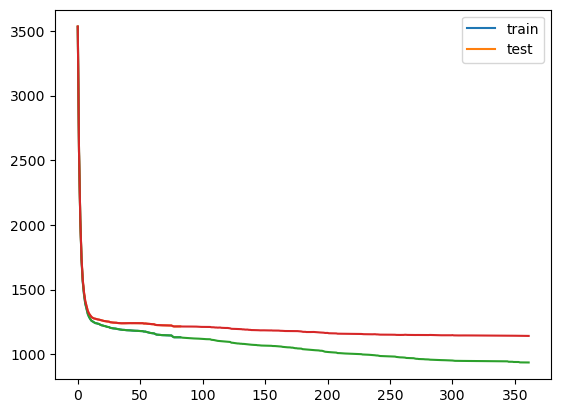

Node: 369 train sse: 935.519575049853 test sse: 1140.9971250402123


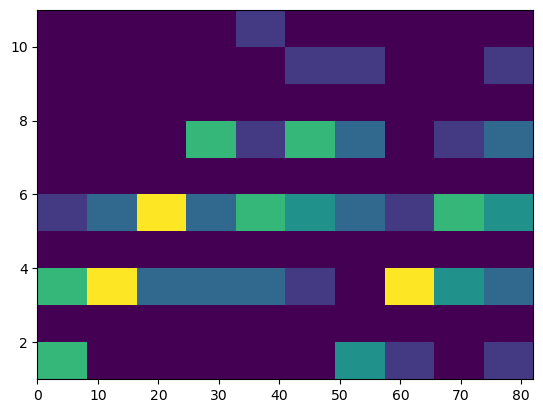

              precision    recall  f1-score   support

           0    0.75528   0.73346   0.74421      1073
           1    0.76689   0.82773   0.79615      1399
           2    0.84103   0.93182   0.88410       176
           3    1.00000   0.50000   0.66667        10
           4    1.00000   0.05882   0.11111        51
           5    0.91045   0.64894   0.75776        94
           6    0.90361   0.73529   0.81081       102

    accuracy                        0.77556      2905
   macro avg    0.88246   0.63372   0.68154      2905
weighted avg    0.78143   0.77556   0.76909      2905

              precision    recall  f1-score   support

           0    0.72154   0.66170   0.69033      1073
           1    0.73219   0.82214   0.77456      1400
           2    0.65854   0.76705   0.70866       176
           3    0.50000   0.18182   0.26667        11
           4    0.00000   0.00000   0.00000        51
           5    0.50000   0.25806   0.34043        93
           6    0.68132 

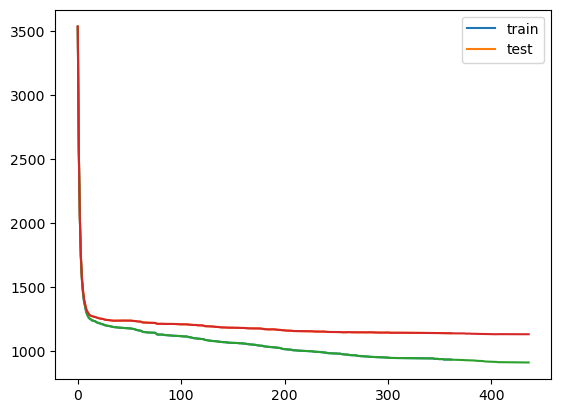

Node: 1854 train sse: 912.8171822327885 test sse: 1133.2222713494546


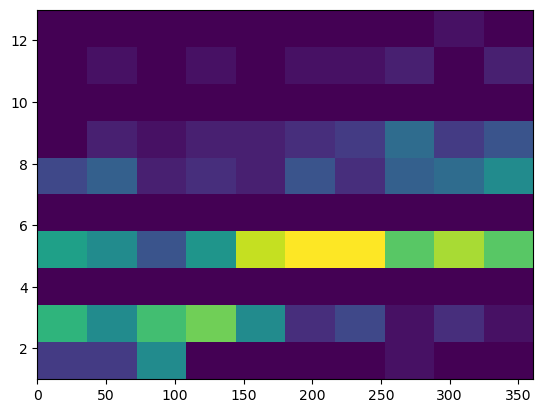

              precision    recall  f1-score   support

           0    0.76035   0.73625   0.74811      1073
           1    0.77071   0.83131   0.79986      1399
           2    0.84896   0.92614   0.88587       176
           3    1.00000   0.50000   0.66667        10
           4    0.83333   0.09804   0.17544        51
           5    0.92958   0.70213   0.80000        94
           6    0.91566   0.74510   0.82162       102

    accuracy                        0.78072      2905
   macro avg    0.86551   0.64842   0.69965      2905
weighted avg    0.78374   0.78072   0.77530      2905

              precision    recall  f1-score   support

           0    0.72081   0.66170   0.68999      1073
           1    0.73138   0.82071   0.77348      1400
           2    0.66834   0.75568   0.70933       176
           3    0.50000   0.18182   0.26667        11
           4    0.00000   0.00000   0.00000        51
           5    0.54717   0.31183   0.39726        93
           6    0.68889 

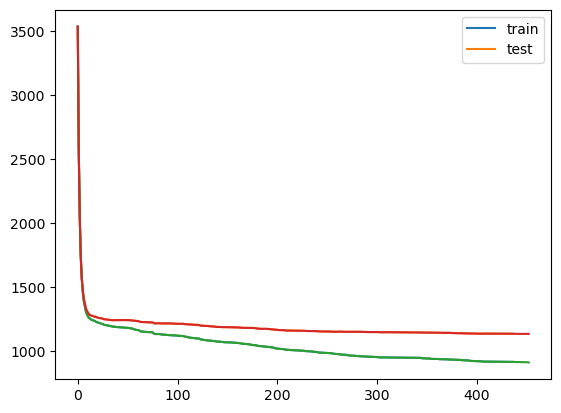

Node: 2181 train sse: 908.2537694388418 test sse: 1131.597786138482


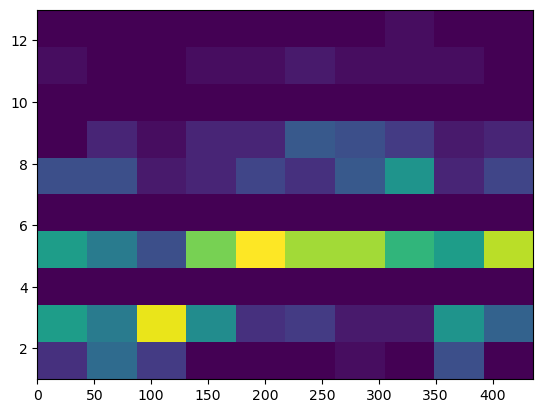

              precision    recall  f1-score   support

           0    0.76222   0.74091   0.75142      1073
           1    0.77357   0.83274   0.80207      1399
           2    0.85789   0.92614   0.89071       176
           3    1.00000   0.50000   0.66667        10
           4    0.83333   0.09804   0.17544        51
           5    0.91781   0.71277   0.80240        94
           6    0.91463   0.73529   0.81522       102

    accuracy                        0.78313      2905
   macro avg    0.86564   0.64941   0.70056      2905
weighted avg    0.78594   0.78313   0.77773      2905

              precision    recall  f1-score   support

           0    0.72477   0.66263   0.69231      1073
           1    0.73287   0.82500   0.77621      1400
           2    0.67513   0.75568   0.71314       176
           3    0.50000   0.18182   0.26667        11
           4    0.00000   0.00000   0.00000        51
           5    0.56364   0.33333   0.41892        93
           6    0.68889 

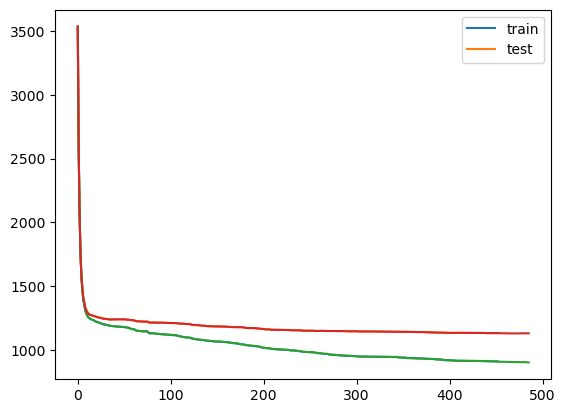

Node: 2241 train sse: 901.6175689459105 test sse: 1130.23905459745


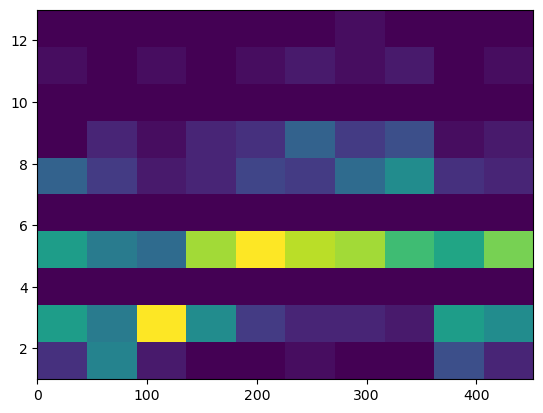

              precision    recall  f1-score   support

           0    0.76381   0.74744   0.75553      1073
           1    0.77822   0.83274   0.80456      1399
           2    0.85789   0.92614   0.89071       176
           3    1.00000   0.50000   0.66667        10
           4    0.85714   0.11765   0.20690        51
           5    0.91892   0.72340   0.80952        94
           6    0.91463   0.73529   0.81522       102

    accuracy                        0.78623      2905
   macro avg    0.87009   0.65467   0.70702      2905
weighted avg    0.78922   0.78623   0.78124      2905

              precision    recall  f1-score   support

           0    0.72340   0.66542   0.69320      1073
           1    0.73312   0.82214   0.77508      1400
           2    0.67172   0.75568   0.71123       176
           3    0.50000   0.18182   0.26667        11
           4    0.00000   0.00000   0.00000        51
           5    0.55556   0.32258   0.40816        93
           6    0.69663 

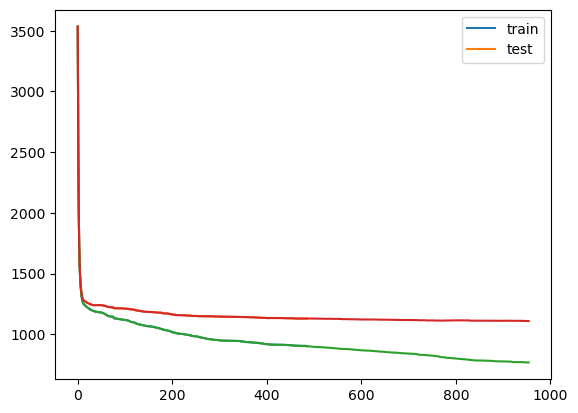

Node: 2370 train sse: 767.6497847594162 test sse: 1108.5890520557427


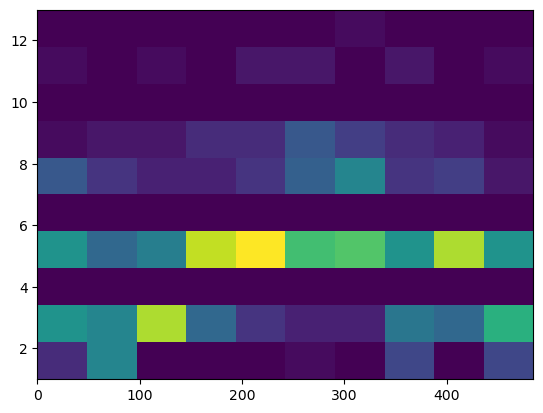

              precision    recall  f1-score   support

           0    0.79981   0.78938   0.79456      1073
           1    0.81547   0.85919   0.83676      1399
           2    0.93785   0.94318   0.94051       176
           3    1.00000   0.90000   0.94737        10
           4    0.94737   0.35294   0.51429        51
           5    0.95294   0.86170   0.90503        94
           6    0.96341   0.77451   0.85870       102

    accuracy                        0.82685      2905
   macro avg    0.91669   0.78299   0.82817      2905
weighted avg    0.82969   0.82685   0.82515      2905

              precision    recall  f1-score   support

           0    0.73026   0.66356   0.69531      1073
           1    0.73422   0.83071   0.77949      1400
           2    0.67895   0.73295   0.70492       176
           3    0.50000   0.27273   0.35294        11
           4    0.00000   0.00000   0.00000        51
           5    0.55172   0.34409   0.42384        93
           6    0.68966 

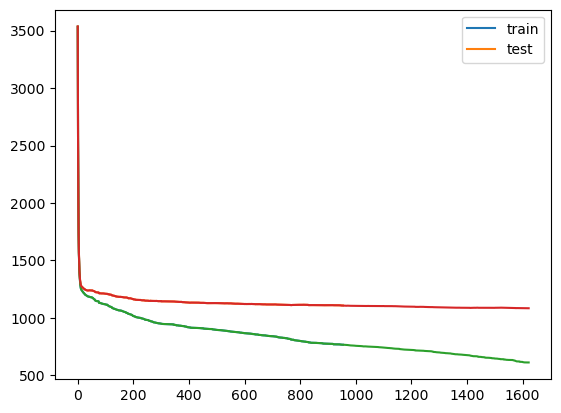

Node: 5085 train sse: 613.1800843240121 test sse: 1084.6950289011982


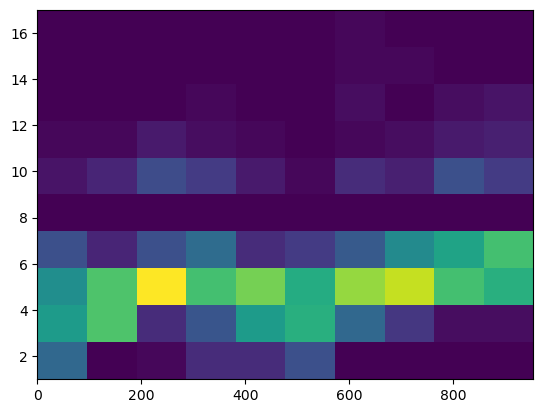

              precision    recall  f1-score   support

           0    0.85688   0.85368   0.85528      1073
           1    0.86915   0.90207   0.88530      1399
           2    0.98266   0.96591   0.97421       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   0.50980   0.67532        51
           5    0.98889   0.94681   0.96739        94
           6    0.98824   0.82353   0.89840       102

    accuracy                        0.88021      2905
   macro avg    0.95511   0.85740   0.89370      2905
weighted avg    0.88229   0.88021   0.87942      2905

              precision    recall  f1-score   support

           0    0.73917   0.68406   0.71055      1073
           1    0.74569   0.83357   0.78718      1400
           2    0.69355   0.73295   0.71271       176
           3    0.50000   0.36364   0.42105        11
           4    0.10000   0.01961   0.03279        51
           5    0.54839   0.36559   0.43871        93
           6    0.70370 

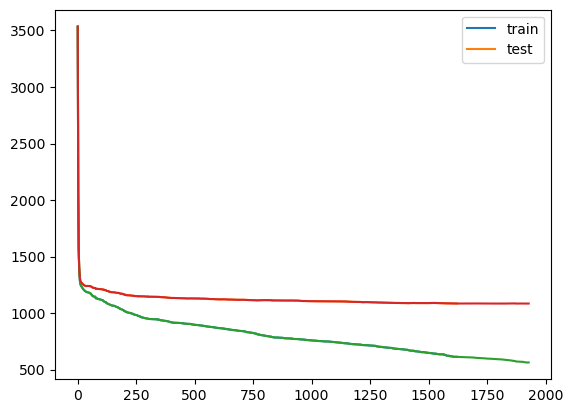

Node: 9073 train sse: 563.1941690537852 test sse: 1084.4911378291793


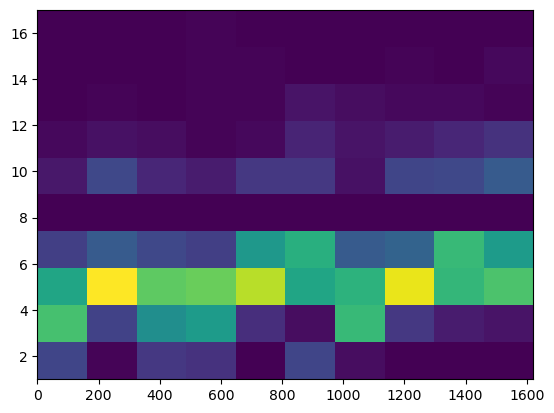

              precision    recall  f1-score   support

           0    0.87160   0.86673   0.86916      1073
           1    0.87923   0.91065   0.89466      1399
           2    0.98844   0.97159   0.97994       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   0.54902   0.70886        51
           5    0.98889   0.94681   0.96739        94
           6    1.00000   0.86275   0.92632       102

    accuracy                        0.89157      2905
   macro avg    0.96117   0.87251   0.90662      2905
weighted avg    0.89335   0.89157   0.89097      2905

              precision    recall  f1-score   support

           0    0.73752   0.68872   0.71229      1073
           1    0.74823   0.83000   0.78700      1400
           2    0.69945   0.72727   0.71309       176
           3    0.50000   0.36364   0.42105        11
           4    0.30000   0.05882   0.09836        51
           5    0.55385   0.38710   0.45570        93
           6    0.69048 

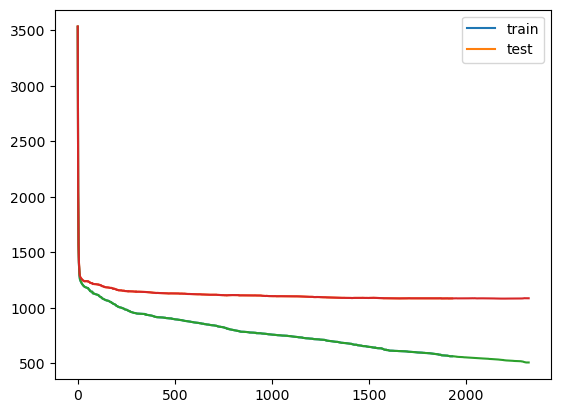

Node: 10727 train sse: 507.1154644309962 test sse: 1085.809507716526


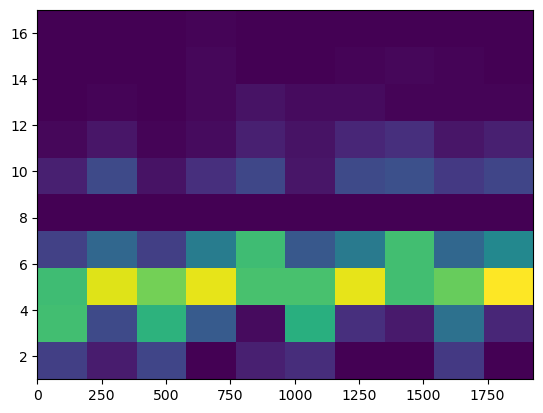

              precision    recall  f1-score   support

           0    0.88505   0.88257   0.88381      1073
           1    0.89562   0.91994   0.90762      1399
           2    1.00000   0.98295   0.99140       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   0.60784   0.75610        51
           5    0.98925   0.97872   0.98396        94
           6    1.00000   0.89216   0.94301       102

    accuracy                        0.90568      2905
   macro avg    0.96713   0.89488   0.92370      2905
weighted avg    0.90692   0.90568   0.90527      2905

              precision    recall  f1-score   support

           0    0.74122   0.68872   0.71401      1073
           1    0.74984   0.83286   0.78917      1400
           2    0.69355   0.73295   0.71271       176
           3    0.50000   0.36364   0.42105        11
           4    0.30000   0.05882   0.09836        51
           5    0.54839   0.36559   0.43871        93
           6    0.67816 

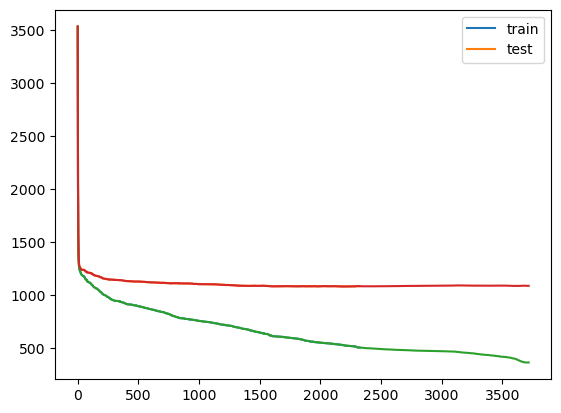

Node: 12935 train sse: 366.06745924861764 test sse: 1089.2971913536408


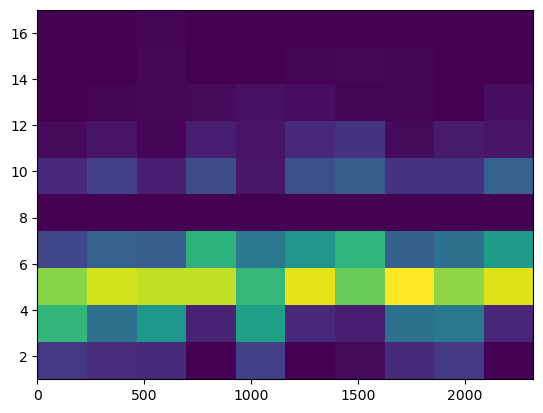

              precision    recall  f1-score   support

           0    0.93444   0.94315   0.93878      1073
           1    0.94744   0.95354   0.95048      1399
           2    1.00000   0.99432   0.99715       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   0.76471   0.86667        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   0.94118   0.96970       102

    accuracy                        0.95009      2905
   macro avg    0.98313   0.94241   0.96040      2905
weighted avg    0.95047   0.95009   0.94996      2905

              precision    recall  f1-score   support

           0    0.73274   0.69245   0.71203      1073
           1    0.74918   0.81929   0.78267      1400
           2    0.68817   0.72727   0.70718       176
           3    0.50000   0.36364   0.42105        11
           4    0.40000   0.07843   0.13115        51
           5    0.52174   0.38710   0.44444        93
           6    0.70115 

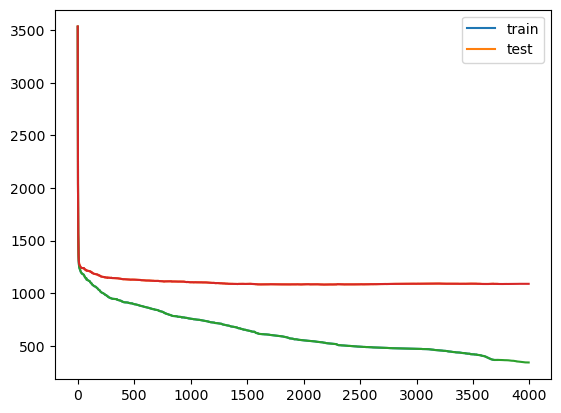

Node: 22385 train sse: 342.43240149563206 test sse: 1089.7572355990972


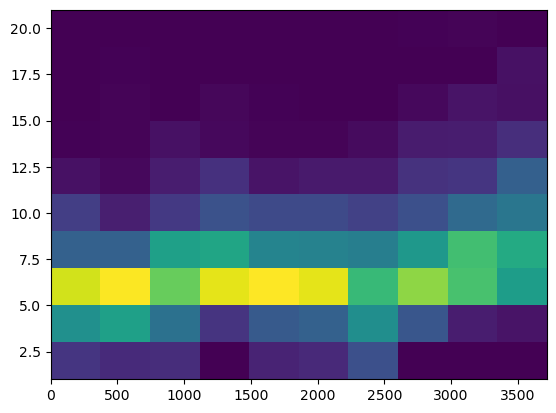

              precision    recall  f1-score   support

           0    0.94352   0.94967   0.94659      1073
           1    0.95252   0.96069   0.95658      1399
           2    1.00000   0.99432   0.99715       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   0.76471   0.86667        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   0.94118   0.96970       102

    accuracy                        0.95594      2905
   macro avg    0.98515   0.94437   0.96238      2905
weighted avg    0.95627   0.95594   0.95578      2905

              precision    recall  f1-score   support

           0    0.73498   0.69525   0.71456      1073
           1    0.75147   0.82071   0.78457      1400
           2    0.69355   0.73295   0.71271       176
           3    0.50000   0.36364   0.42105        11
           4    0.40000   0.07843   0.13115        51
           5    0.53623   0.39785   0.45679        93
           6    0.69318 

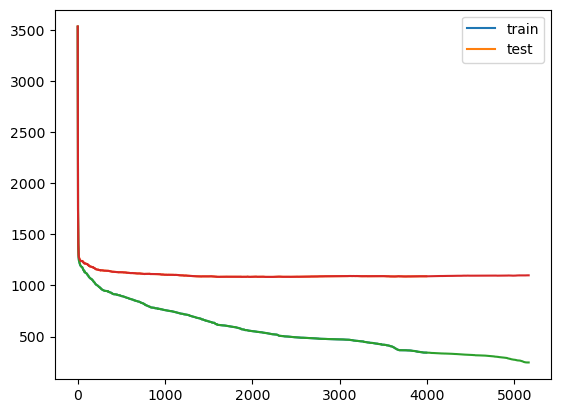

Node: 23838 train sse: 246.16672099653957 test sse: 1099.248827471682


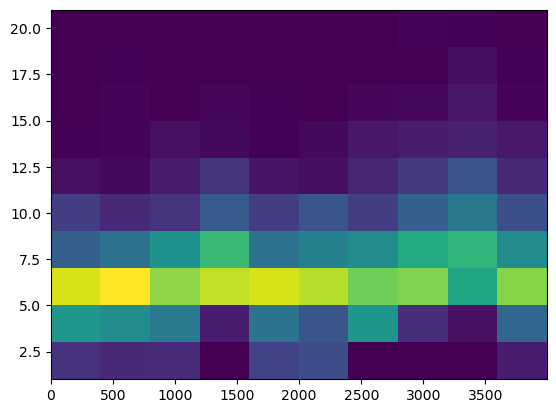

              precision    recall  f1-score   support

           0    0.97872   0.98602   0.98236      1073
           1    0.98569   0.98499   0.98534      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   0.90196   0.94845        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   0.98039   0.99010       102

    accuracy                        0.98520      2905
   macro avg    0.99492   0.97905   0.98661      2905
weighted avg    0.98525   0.98520   0.98517      2905

              precision    recall  f1-score   support

           0    0.73431   0.69804   0.71572      1073
           1    0.75295   0.82071   0.78537      1400
           2    0.68649   0.72159   0.70360       176
           3    0.44444   0.36364   0.40000        11
           4    0.55556   0.09804   0.16667        51
           5    0.51471   0.37634   0.43478        93
           6    0.70455 

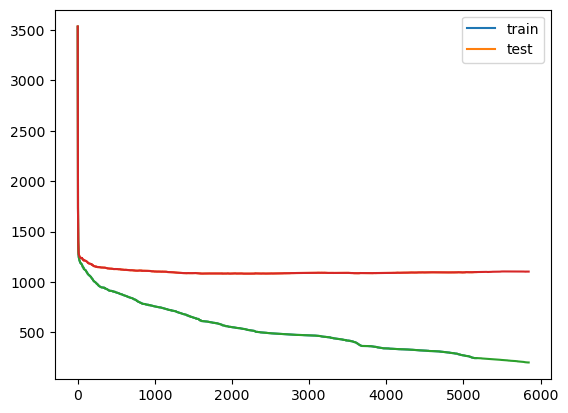

Node: 31637 train sse: 202.64649515667435 test sse: 1104.1319102705352


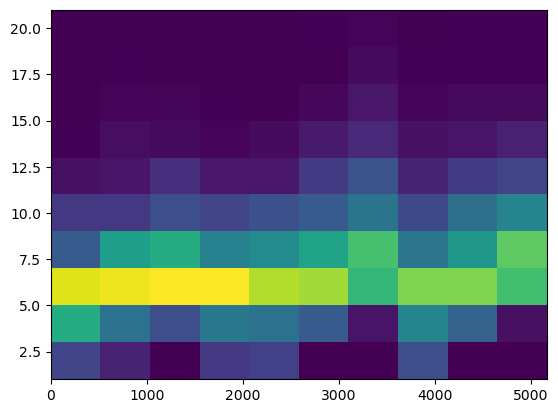

              precision    recall  f1-score   support

           0    0.98796   0.99441   0.99118      1073
           1    0.99427   0.99142   0.99284      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   0.96078   0.98000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   0.99020   0.99507       102

    accuracy                        0.99277      2905
   macro avg    0.99746   0.99097   0.99416      2905
weighted avg    0.99279   0.99277   0.99277      2905

              precision    recall  f1-score   support

           0    0.72772   0.69245   0.70965      1073
           1    0.75181   0.81571   0.78246      1400
           2    0.68254   0.73295   0.70685       176
           3    0.44444   0.36364   0.40000        11
           4    0.55556   0.09804   0.16667        51
           5    0.50725   0.37634   0.43210        93
           6    0.69663 

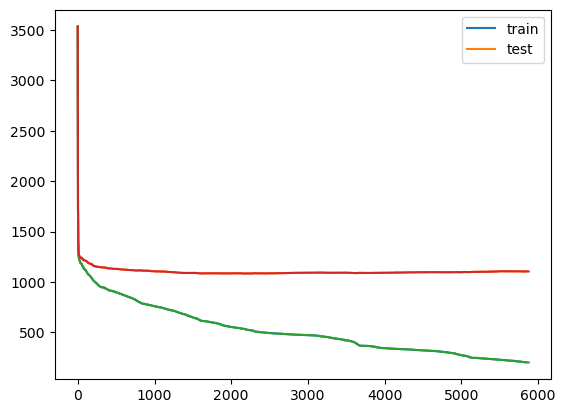

Node: 36007 train sse: 200.43215066695132 test sse: 1104.0644215653697


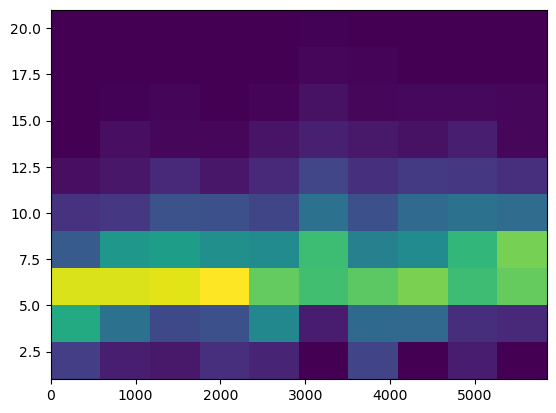

              precision    recall  f1-score   support

           0    0.98705   0.99441   0.99071      1073
           1    0.99497   0.99071   0.99284      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   0.98039   0.99010        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   0.99020   0.99507       102

    accuracy                        0.99277      2905
   macro avg    0.99743   0.99367   0.99553      2905
weighted avg    0.99280   0.99277   0.99277      2905

              precision    recall  f1-score   support

           0    0.72727   0.69338   0.70992      1073
           1    0.75132   0.81357   0.78121      1400
           2    0.68254   0.73295   0.70685       176
           3    0.44444   0.36364   0.40000        11
           4    0.55556   0.09804   0.16667        51
           5    0.50000   0.37634   0.42945        93
           6    0.69663 

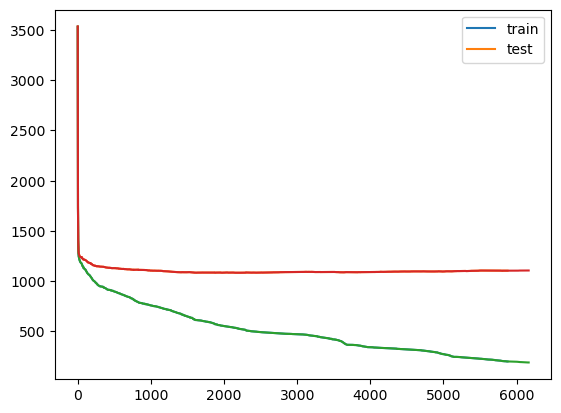

Node: 36121 train sse: 190.35461308466904 test sse: 1106.0208990785673


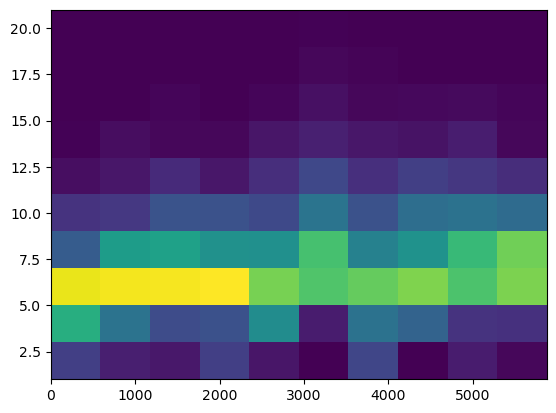

              precision    recall  f1-score   support

           0    0.98708   0.99720   0.99212      1073
           1    0.99784   0.99071   0.99426      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   0.99020   0.99507       102

    accuracy                        0.99415      2905
   macro avg    0.99785   0.99687   0.99735      2905
weighted avg    0.99419   0.99415   0.99415      2905

              precision    recall  f1-score   support

           0    0.72923   0.69525   0.71183      1073
           1    0.75214   0.81714   0.78329      1400
           2    0.68984   0.73295   0.71074       176
           3    0.44444   0.36364   0.40000        11
           4    0.55556   0.09804   0.16667        51
           5    0.52174   0.38710   0.44444        93
           6    0.71264 

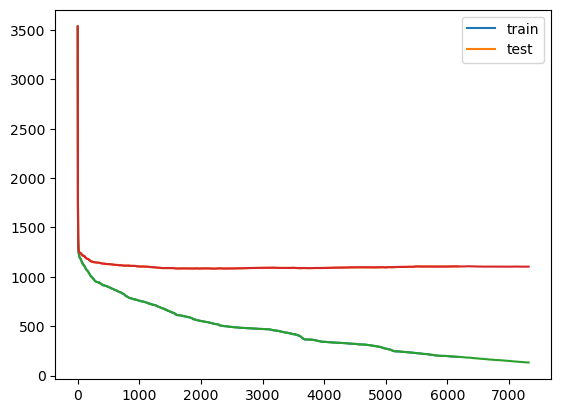

Node: 37702 train sse: 133.0245998538752 test sse: 1103.5699440002907


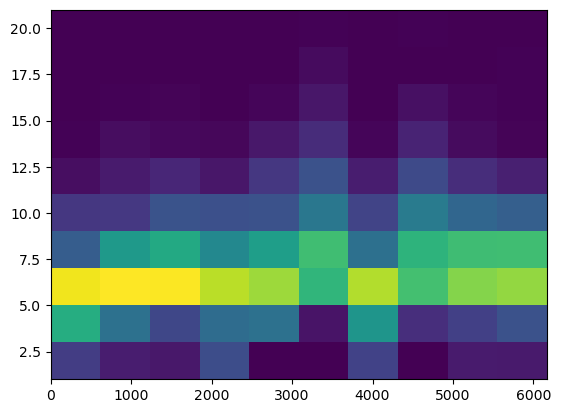

              precision    recall  f1-score   support

           0    0.99536   1.00000   0.99768      1073
           1    1.00000   0.99643   0.99821      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        0.99828      2905
   macro avg    0.99934   0.99949   0.99941      2905
weighted avg    0.99829   0.99828   0.99828      2905

              precision    recall  f1-score   support

           0    0.73133   0.70270   0.71673      1073
           1    0.75947   0.81643   0.78692      1400
           2    0.69681   0.74432   0.71978       176
           3    0.44444   0.36364   0.40000        11
           4    0.55556   0.09804   0.16667        51
           5    0.50000   0.38710   0.43636        93
           6    0.70330 

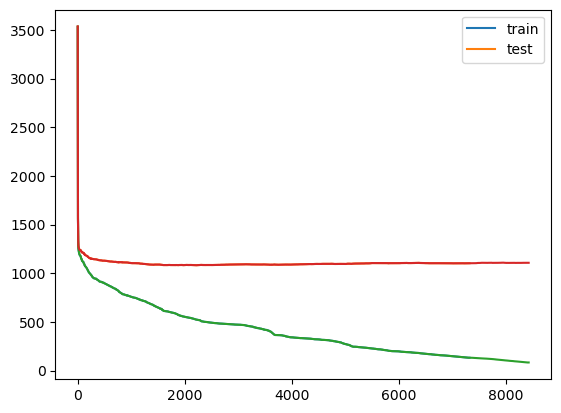

Node: 45575 train sse: 84.09895400824696 test sse: 1107.9585604881192


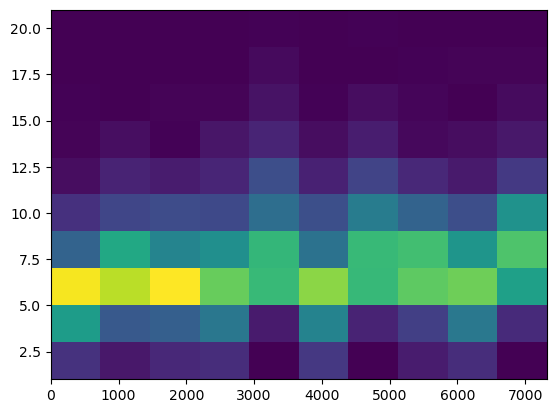

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.72955   0.70643   0.71780      1073
           1    0.75954   0.81000   0.78396      1400
           2    0.68229   0.74432   0.71196       176
           3    0.44444   0.36364   0.40000        11
           4    0.44444   0.07843   0.13333        51
           5    0.48611   0.37634   0.42424        93
           6    0.71429 

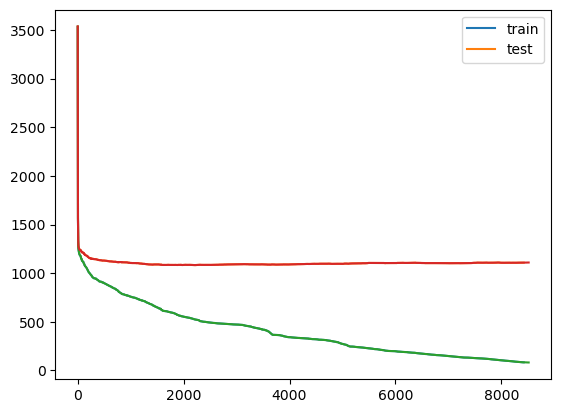

Node: 52892 train sse: 82.38835183837537 test sse: 1109.6642247402783


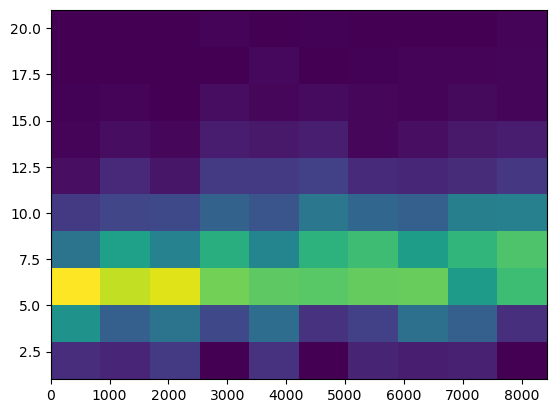

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.73495   0.70550   0.71992      1073
           1    0.76133   0.81571   0.78759      1400
           2    0.68586   0.74432   0.71390       176
           3    0.44444   0.36364   0.40000        11
           4    0.44444   0.07843   0.13333        51
           5    0.49315   0.38710   0.43373        93
           6    0.69892 

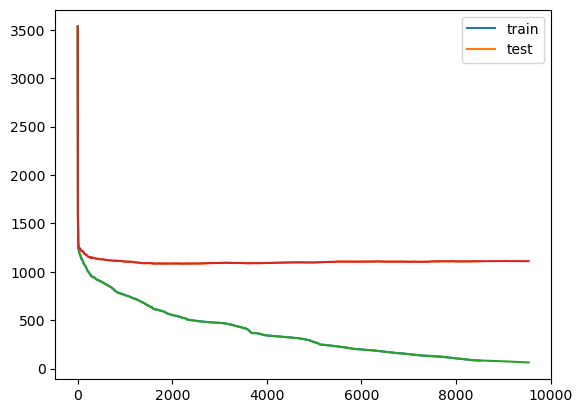

Node: 53313 train sse: 62.26846744187279 test sse: 1109.8572762110716


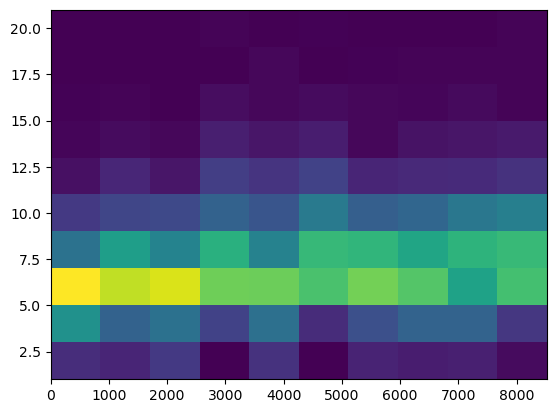

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.74027   0.70923   0.72442      1073
           1    0.76381   0.82000   0.79091      1400
           2    0.68947   0.74432   0.71585       176
           3    0.44444   0.36364   0.40000        11
           4    0.44444   0.07843   0.13333        51
           5    0.49315   0.38710   0.43373        93
           6    0.69892 

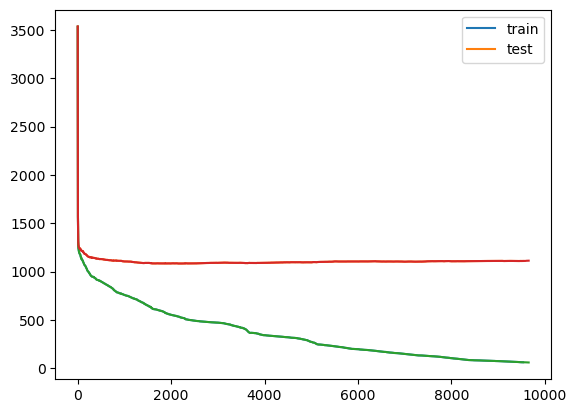

Node: 60138 train sse: 60.11081522643791 test sse: 1113.036080892689


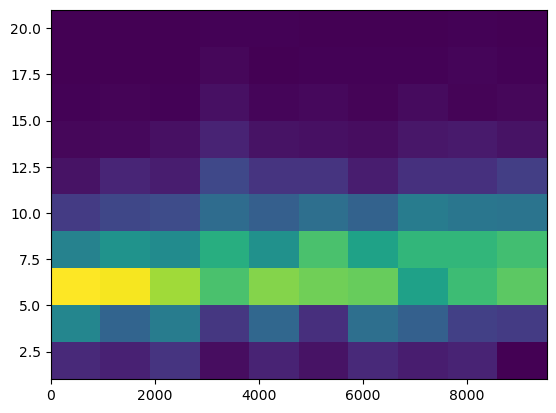

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.73833   0.70736   0.72251      1073
           1    0.76263   0.81929   0.78994      1400
           2    0.68586   0.74432   0.71390       176
           3    0.44444   0.36364   0.40000        11
           4    0.44444   0.07843   0.13333        51
           5    0.49296   0.37634   0.42683        93
           6    0.69892 

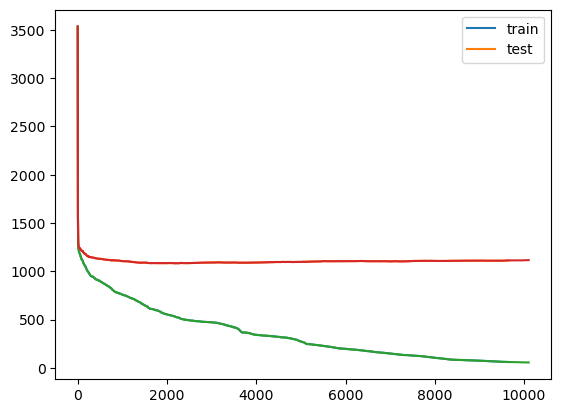

Node: 60711 train sse: 55.82706555355529 test sse: 1115.5233746523468


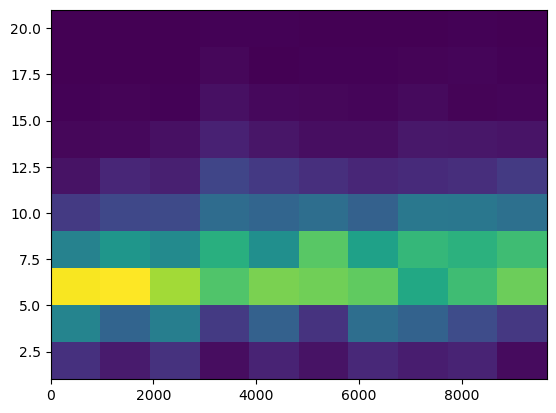

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.74031   0.71202   0.72589      1073
           1    0.76431   0.82000   0.79118      1400
           2    0.69149   0.73864   0.71429       176
           3    0.44444   0.36364   0.40000        11
           4    0.44444   0.07843   0.13333        51
           5    0.49315   0.38710   0.43373        93
           6    0.70652 

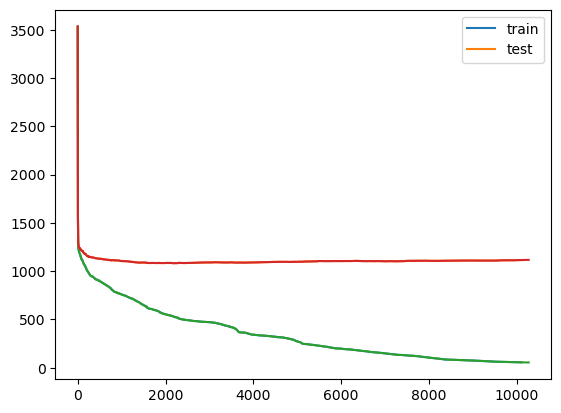

Node: 63424 train sse: 54.34566157259482 test sse: 1117.4269260332708


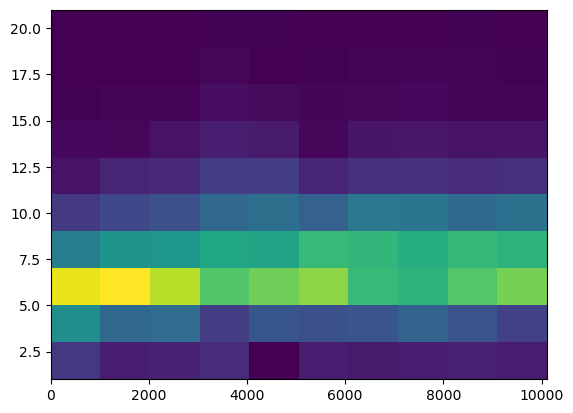

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.73959   0.71202   0.72555      1073
           1    0.76451   0.81857   0.79062      1400
           2    0.69149   0.73864   0.71429       176
           3    0.44444   0.36364   0.40000        11
           4    0.36364   0.07843   0.12903        51
           5    0.48611   0.37634   0.42424        93
           6    0.69892 

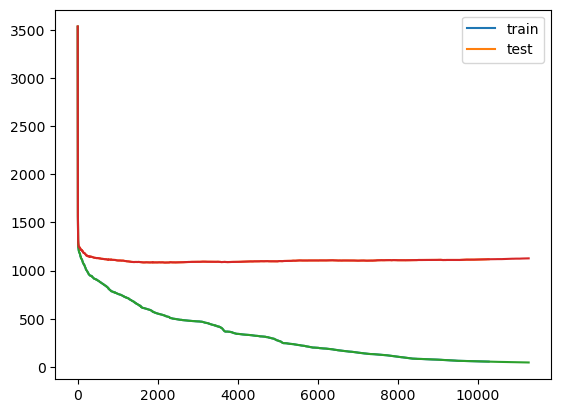

Node: 64331 train sse: 45.212074697148175 test sse: 1126.647777831383


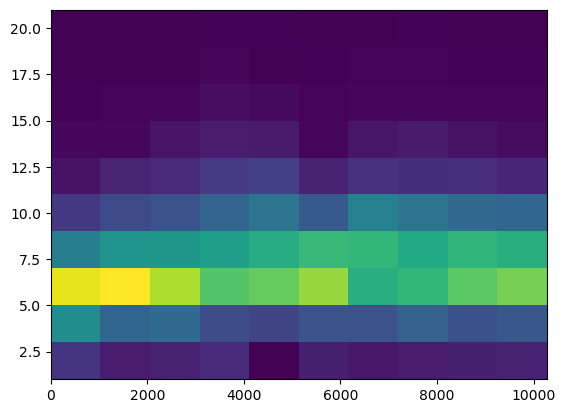

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.73905   0.70736   0.72286      1073
           1    0.76228   0.82000   0.79009      1400
           2    0.69149   0.73864   0.71429       176
           3    0.44444   0.36364   0.40000        11
           4    0.36364   0.07843   0.12903        51
           5    0.48611   0.37634   0.42424        93
           6    0.69565 

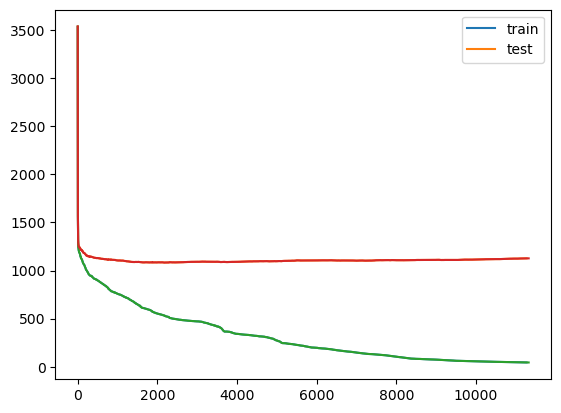

Node: 71178 train sse: 44.97585914125278 test sse: 1126.52367583851


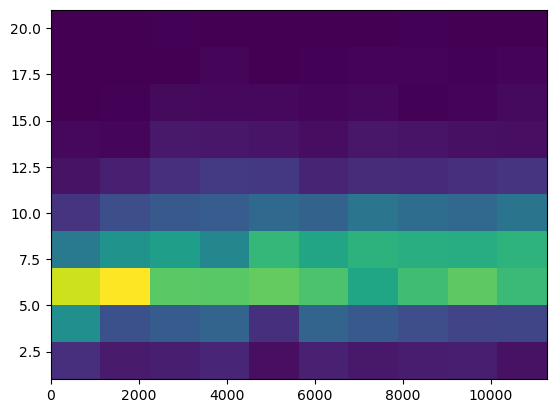

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.73977   0.70736   0.72320      1073
           1    0.76244   0.82071   0.79051      1400
           2    0.69149   0.73864   0.71429       176
           3    0.44444   0.36364   0.40000        11
           4    0.36364   0.07843   0.12903        51
           5    0.48611   0.37634   0.42424        93
           6    0.69565 

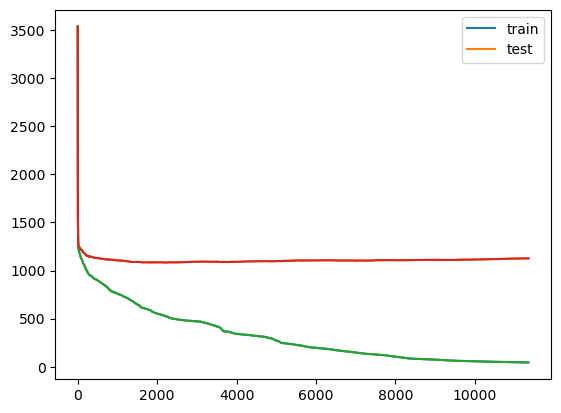

Node: 71415 train sse: 44.71990584824704 test sse: 1126.7037939267498


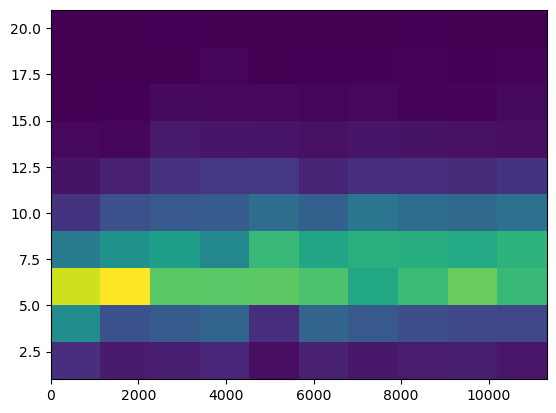

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.73761   0.70736   0.72217      1073
           1    0.76197   0.81857   0.78926      1400
           2    0.69149   0.73864   0.71429       176
           3    0.44444   0.36364   0.40000        11
           4    0.36364   0.07843   0.12903        51
           5    0.48611   0.37634   0.42424        93
           6    0.69565 

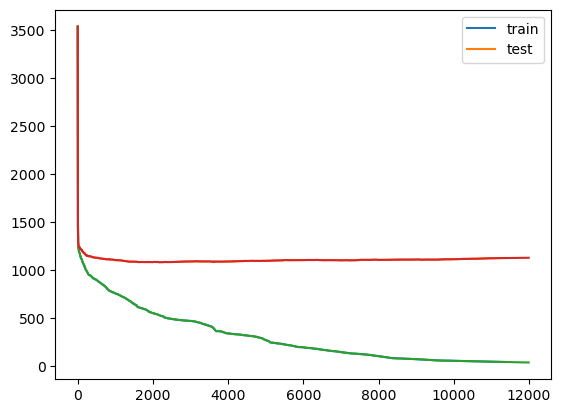

Node: 71552 train sse: 40.042821157092874 test sse: 1129.173138170866


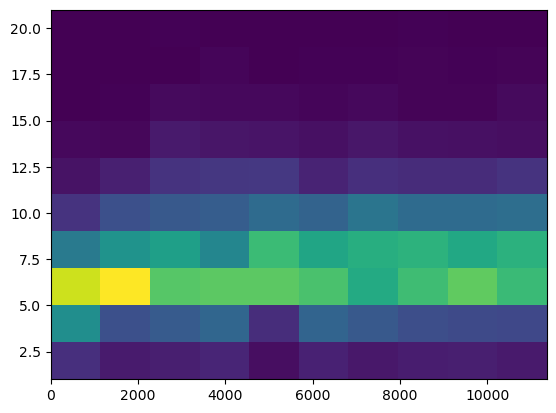

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.73854   0.70550   0.72164      1073
           1    0.76213   0.81929   0.78967      1400
           2    0.69149   0.73864   0.71429       176
           3    0.44444   0.36364   0.40000        11
           4    0.33333   0.07843   0.12698        51
           5    0.49315   0.38710   0.43373        93
           6    0.68817 

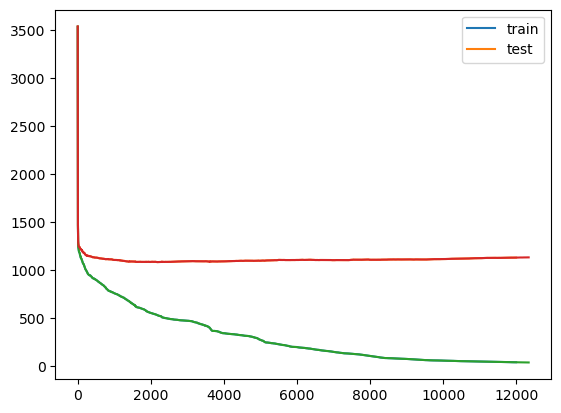

Node: 75750 train sse: 37.82419475188539 test sse: 1131.747088610376


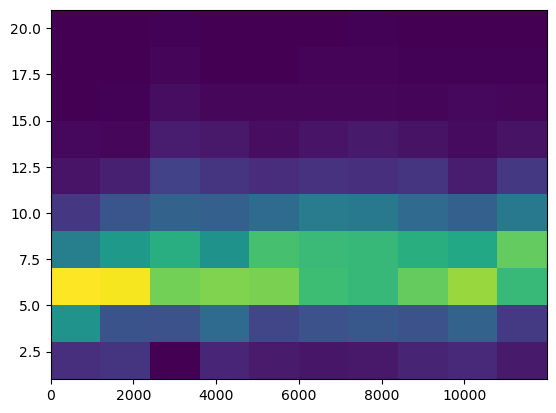

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.74020   0.70363   0.72145      1073
           1    0.76190   0.82286   0.79121      1400
           2    0.69892   0.73864   0.71823       176
           3    0.44444   0.36364   0.40000        11
           4    0.33333   0.07843   0.12698        51
           5    0.49315   0.38710   0.43373        93
           6    0.68817 

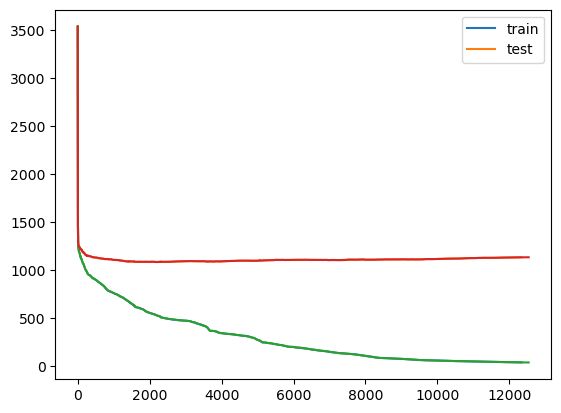

Node: 77728 train sse: 36.88811717122521 test sse: 1132.2360808488027


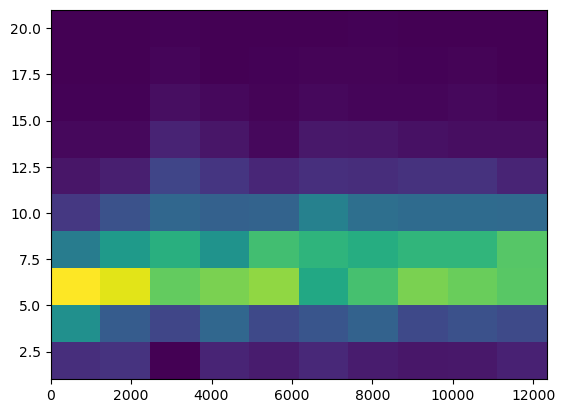

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.73973   0.70457   0.72172      1073
           1    0.76225   0.82214   0.79107      1400
           2    0.69892   0.73864   0.71823       176
           3    0.44444   0.36364   0.40000        11
           4    0.33333   0.07843   0.12698        51
           5    0.49315   0.38710   0.43373        93
           6    0.68817 

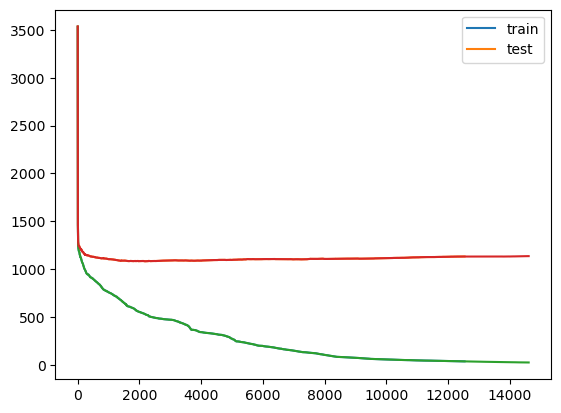

Node: 78827 train sse: 25.375293699754785 test sse: 1136.305925737898


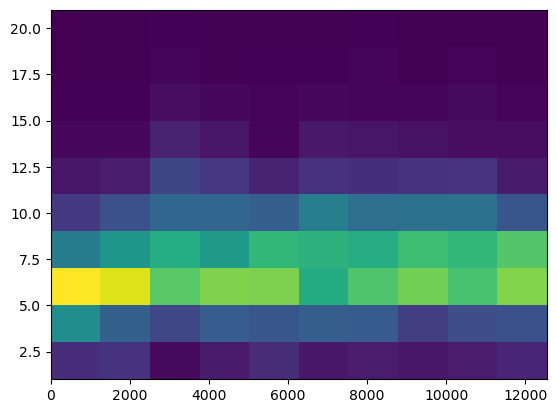

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.73812   0.70923   0.72338      1073
           1    0.76518   0.81929   0.79131      1400
           2    0.69681   0.74432   0.71978       176
           3    0.44444   0.36364   0.40000        11
           4    0.41667   0.09804   0.15873        51
           5    0.50000   0.38710   0.43636        93
           6    0.69149 

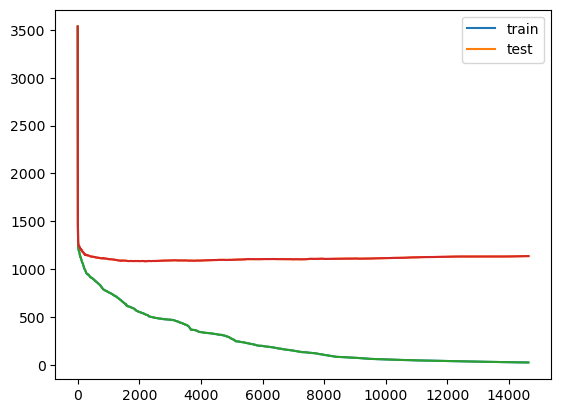

Node: 94425 train sse: 25.131933132911666 test sse: 1136.403506019994


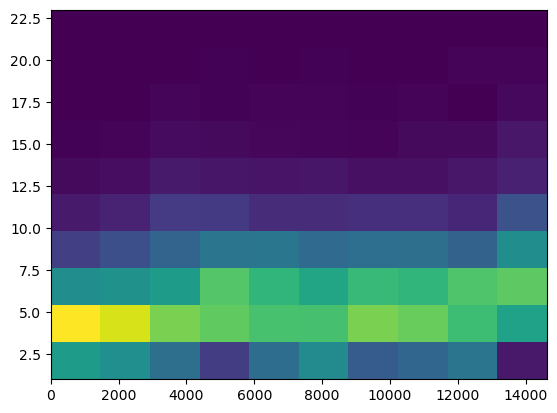

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.74031   0.71202   0.72589      1073
           1    0.76687   0.82000   0.79254      1400
           2    0.68947   0.74432   0.71585       176
           3    0.44444   0.36364   0.40000        11
           4    0.41667   0.09804   0.15873        51
           5    0.49296   0.37634   0.42683        93
           6    0.69149 

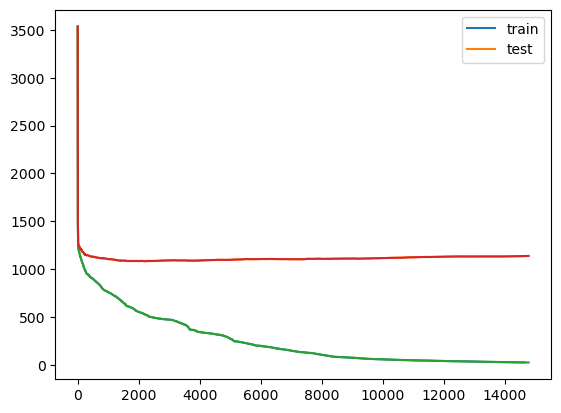

Node: 94516 train sse: 24.58642306367264 test sse: 1137.7571022380073


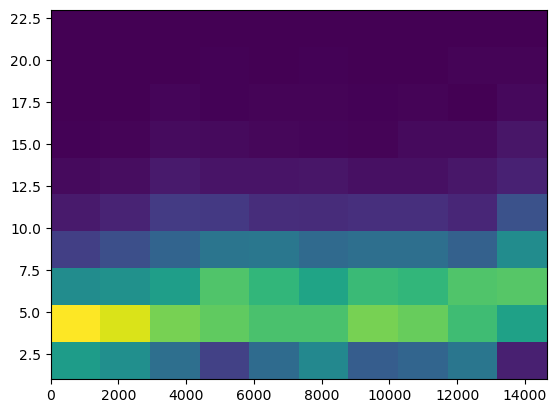

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.74319   0.71202   0.72727      1073
           1    0.76667   0.82143   0.79310      1400
           2    0.68947   0.74432   0.71585       176
           3    0.44444   0.36364   0.40000        11
           4    0.38462   0.09804   0.15625        51
           5    0.49296   0.37634   0.42683        93
           6    0.69149 

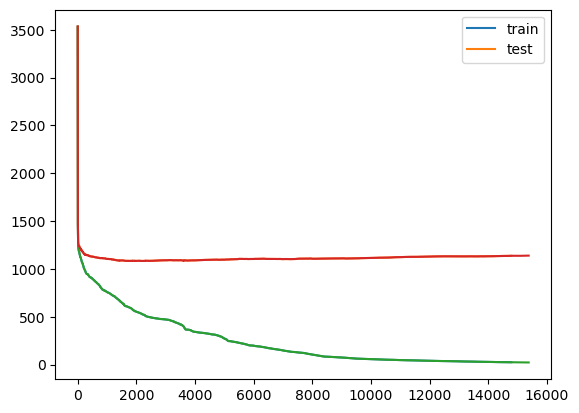

Node: 95235 train sse: 22.252863333155133 test sse: 1139.5578955220947


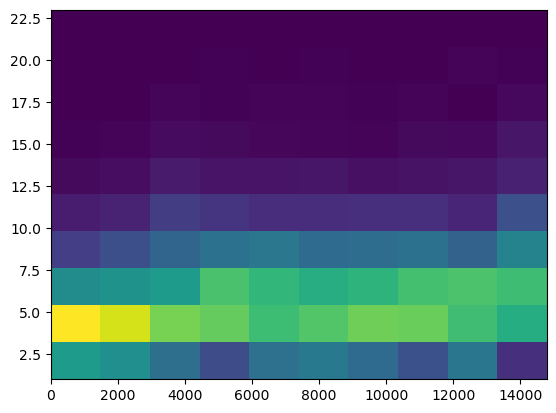

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.73955   0.70923   0.72407      1073
           1    0.76616   0.82143   0.79283      1400
           2    0.69681   0.74432   0.71978       176
           3    0.44444   0.36364   0.40000        11
           4    0.41667   0.09804   0.15873        51
           5    0.50000   0.38710   0.43636        93
           6    0.68085 

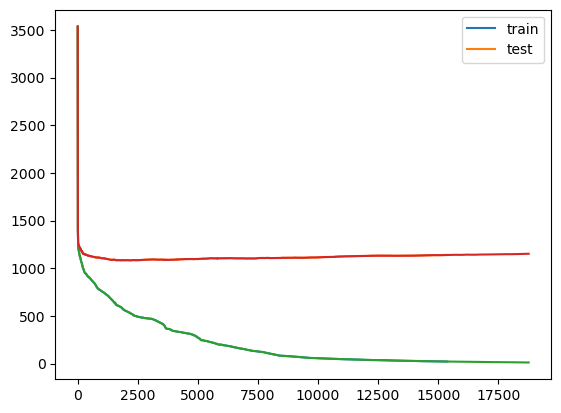

Node: 98974 train sse: 12.399909414404096 test sse: 1152.2293007560463


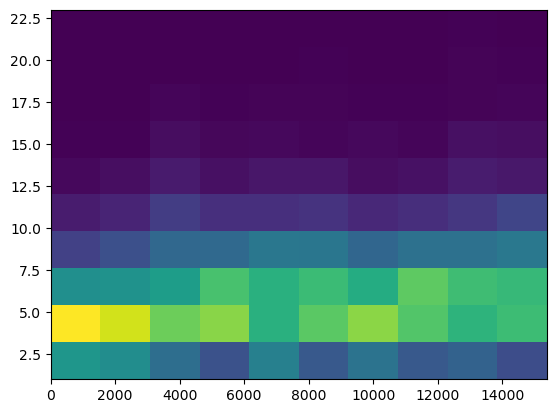

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.73791   0.71109   0.72425      1073
           1    0.76557   0.81643   0.79018      1400
           2    0.68947   0.74432   0.71585       176
           3    0.50000   0.36364   0.42105        11
           4    0.42857   0.11765   0.18462        51
           5    0.48611   0.37634   0.42424        93
           6    0.69149 

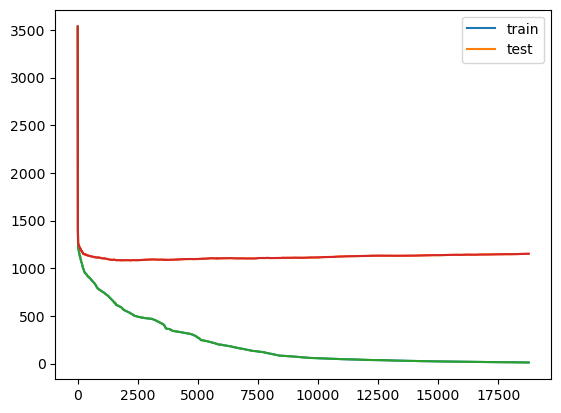

Node: 124786 train sse: 12.386231594453069 test sse: 1152.2252436859662


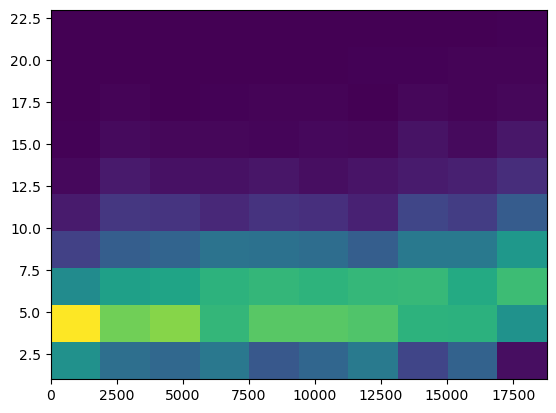

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.73791   0.71109   0.72425      1073
           1    0.76557   0.81643   0.79018      1400
           2    0.68947   0.74432   0.71585       176
           3    0.50000   0.36364   0.42105        11
           4    0.42857   0.11765   0.18462        51
           5    0.48611   0.37634   0.42424        93
           6    0.69149 

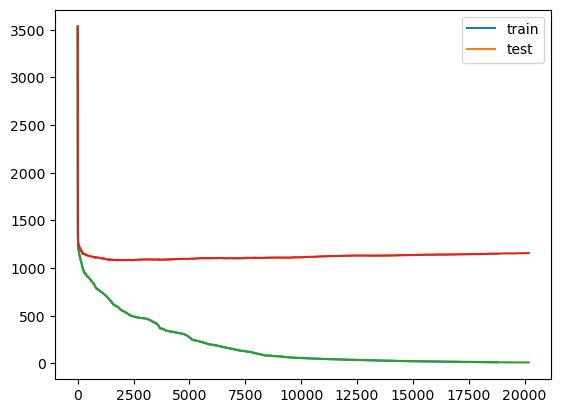

Node: 124788 train sse: 10.374544647345388 test sse: 1158.6456351454697


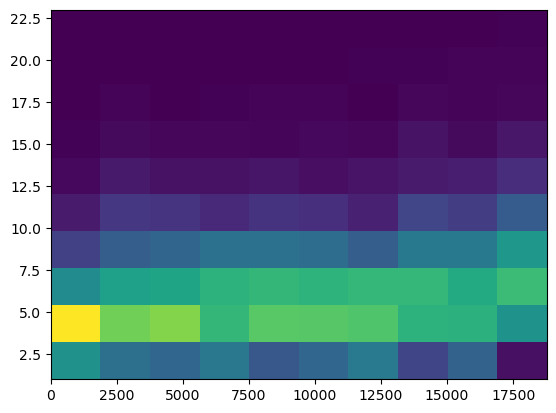

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.74125   0.71016   0.72537      1073
           1    0.76687   0.82000   0.79254      1400
           2    0.69312   0.74432   0.71781       176
           3    0.50000   0.36364   0.42105        11
           4    0.41667   0.09804   0.15873        51
           5    0.49333   0.39785   0.44048        93
           6    0.67708 

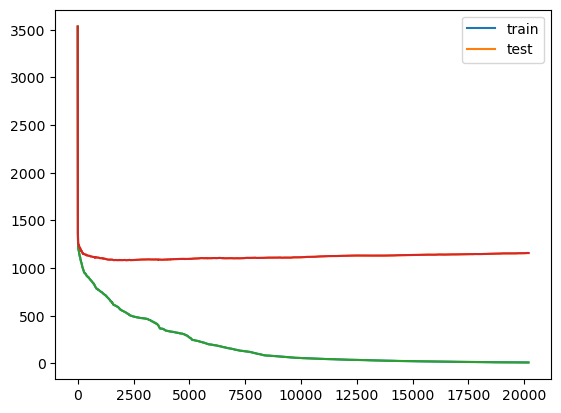

Node: 134508 train sse: 10.243747499879767 test sse: 1158.448333541599


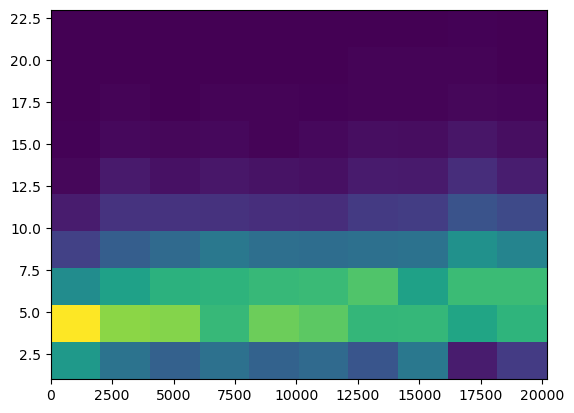

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.74027   0.70923   0.72442      1073
           1    0.76620   0.81929   0.79185      1400
           2    0.69312   0.74432   0.71781       176
           3    0.50000   0.36364   0.42105        11
           4    0.41667   0.09804   0.15873        51
           5    0.49333   0.39785   0.44048        93
           6    0.67708 

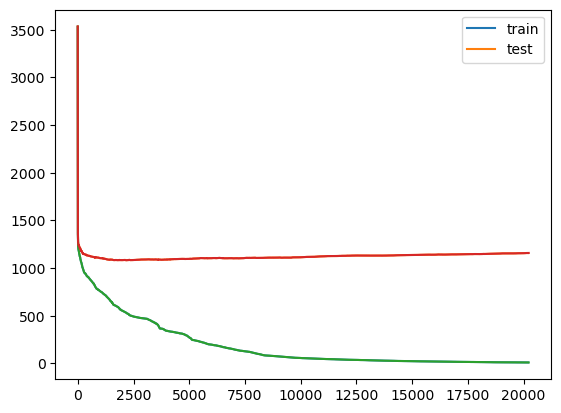

Node: 134588 train sse: 10.267288911070318 test sse: 1158.9618595053178


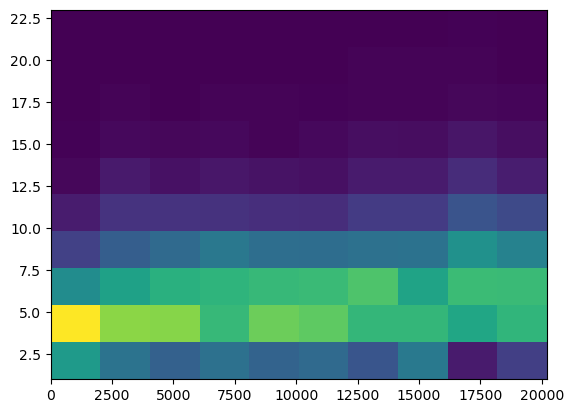

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.73977   0.70736   0.72320      1073
           1    0.76518   0.81929   0.79131      1400
           2    0.69312   0.74432   0.71781       176
           3    0.50000   0.36364   0.42105        11
           4    0.41667   0.09804   0.15873        51
           5    0.49333   0.39785   0.44048        93
           6    0.67708 

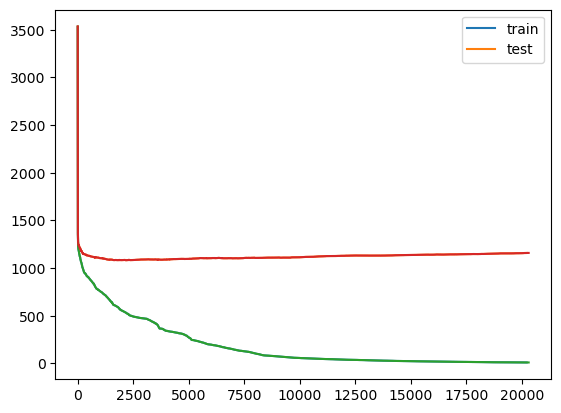

Node: 134665 train sse: 10.15507316434988 test sse: 1159.4045107652032


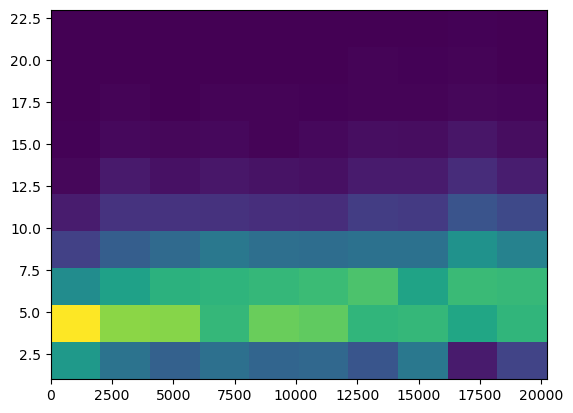

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.73833   0.70736   0.72251      1073
           1    0.76537   0.81786   0.79075      1400
           2    0.69312   0.74432   0.71781       176
           3    0.50000   0.36364   0.42105        11
           4    0.46154   0.11765   0.18750        51
           5    0.49333   0.39785   0.44048        93
           6    0.67708 

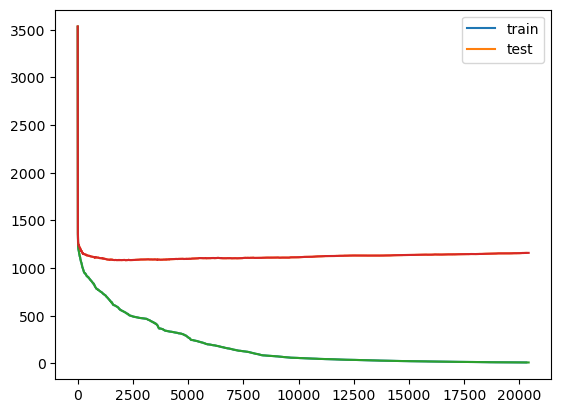

Node: 135066 train sse: 10.045382220250438 test sse: 1159.8772964547272


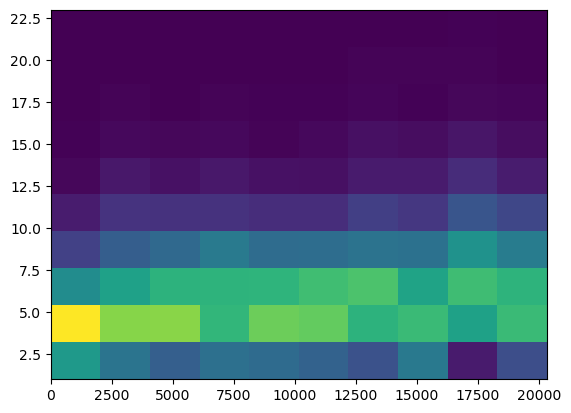

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.73761   0.70736   0.72217      1073
           1    0.76471   0.81714   0.79006      1400
           2    0.69312   0.74432   0.71781       176
           3    0.50000   0.36364   0.42105        11
           4    0.46154   0.11765   0.18750        51
           5    0.48649   0.38710   0.43114        93
           6    0.67708 

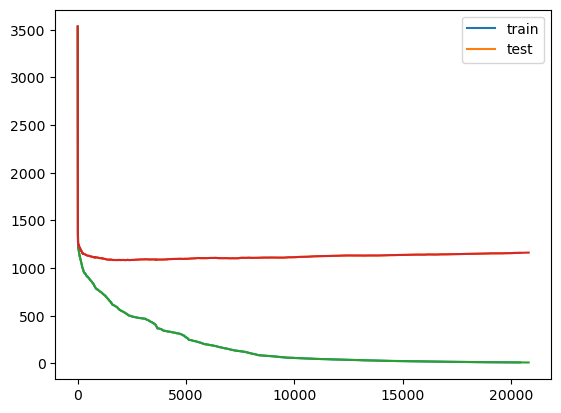

Node: 135544 train sse: 9.44835289517762 test sse: 1162.312895610556


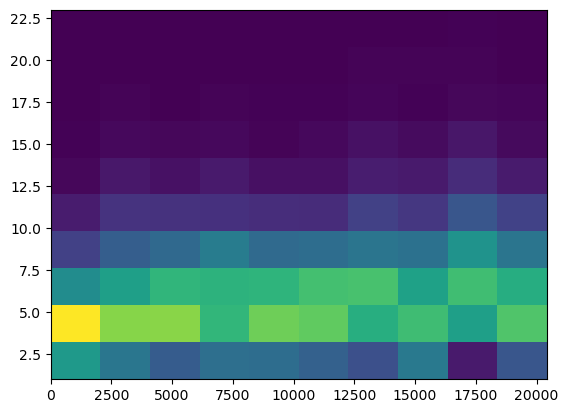

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.73756   0.70457   0.72069      1073
           1    0.76251   0.81643   0.78855      1400
           2    0.69312   0.74432   0.71781       176
           3    0.50000   0.36364   0.42105        11
           4    0.42857   0.11765   0.18462        51
           5    0.49333   0.39785   0.44048        93
           6    0.68421 

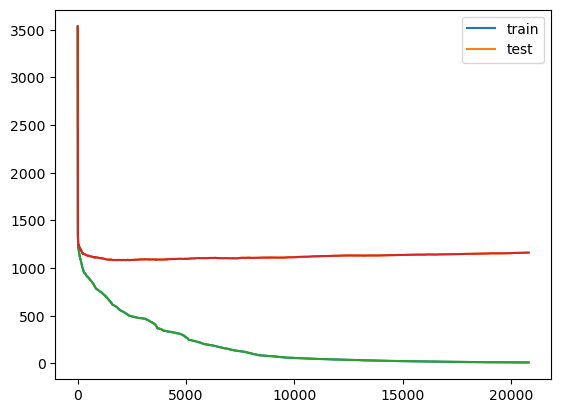

Node: 137860 train sse: 9.453335763890317 test sse: 1162.174592053155


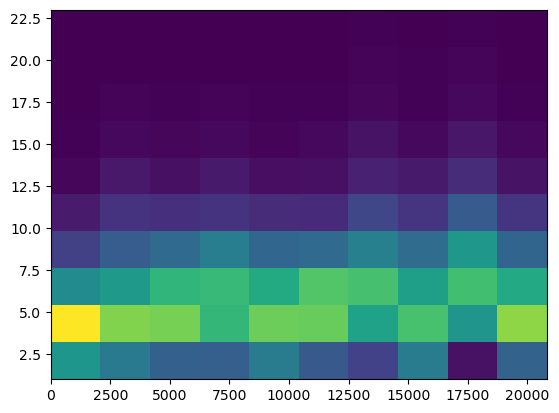

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.73659   0.70363   0.71973      1073
           1    0.76200   0.81643   0.78828      1400
           2    0.68947   0.74432   0.71585       176
           3    0.50000   0.36364   0.42105        11
           4    0.46154   0.11765   0.18750        51
           5    0.48649   0.38710   0.43114        93
           6    0.68421 

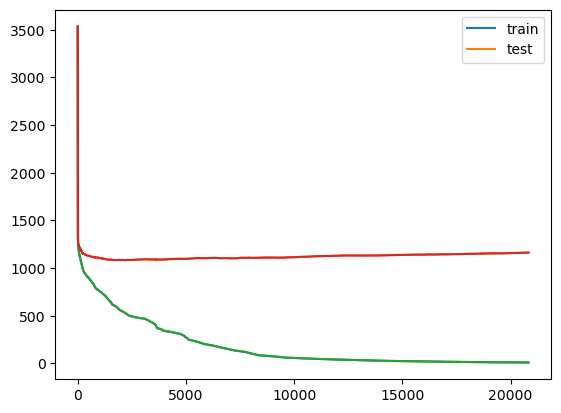

Node: 137875 train sse: 9.404678782873711 test sse: 1162.1520126553175


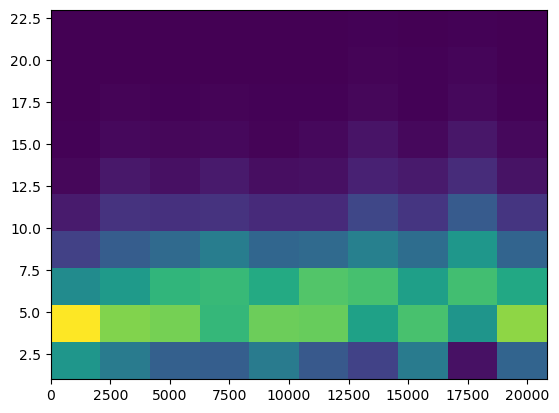

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.73756   0.70457   0.72069      1073
           1    0.76216   0.81714   0.78869      1400
           2    0.68947   0.74432   0.71585       176
           3    0.50000   0.36364   0.42105        11
           4    0.46154   0.11765   0.18750        51
           5    0.47945   0.37634   0.42169        93
           6    0.68421 

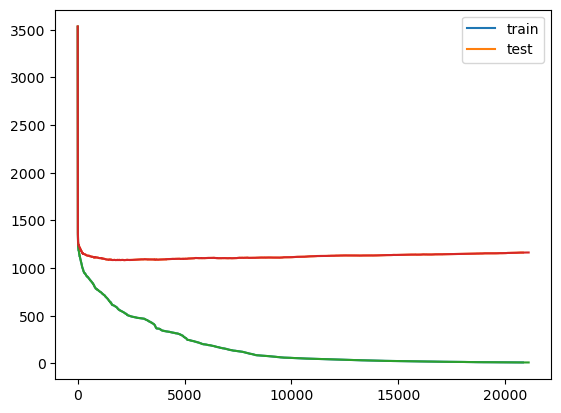

Node: 137959 train sse: 9.268786761259422 test sse: 1163.2900571479308


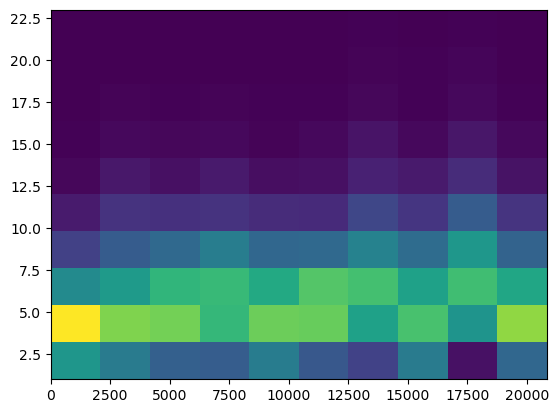

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.73761   0.70736   0.72217      1073
           1    0.76337   0.81571   0.78867      1400
           2    0.69110   0.75000   0.71935       176
           3    0.50000   0.36364   0.42105        11
           4    0.38462   0.09804   0.15625        51
           5    0.47945   0.37634   0.42169        93
           6    0.68421 

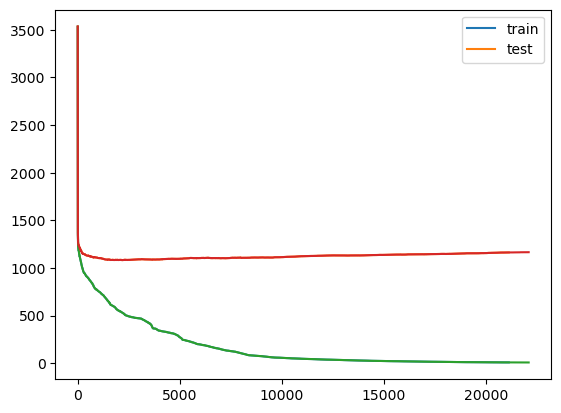

Node: 139400 train sse: 8.556311524666242 test sse: 1166.0169582282645


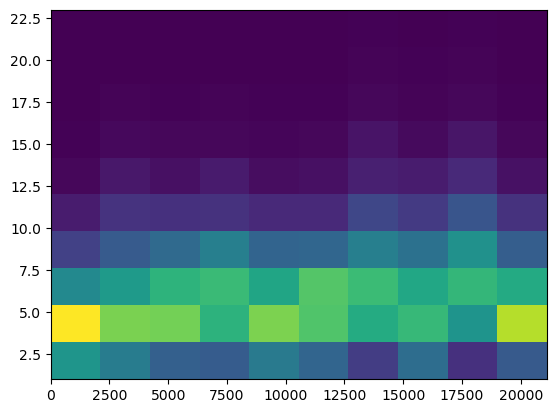

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.74023   0.70643   0.72294      1073
           1    0.76349   0.81857   0.79007      1400
           2    0.69110   0.75000   0.71935       176
           3    0.50000   0.36364   0.42105        11
           4    0.38462   0.09804   0.15625        51
           5    0.48649   0.38710   0.43114        93
           6    0.69149 

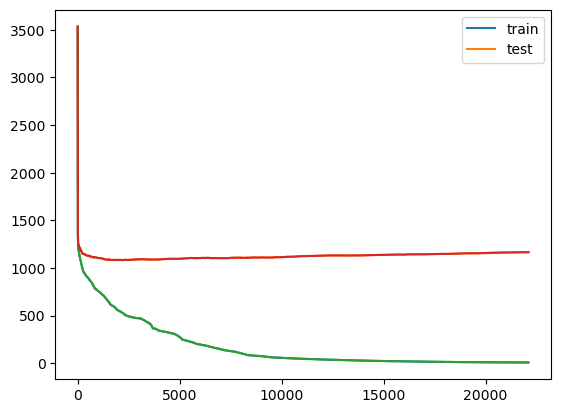

Node: 145686 train sse: 8.46083780272912 test sse: 1166.4122553546563


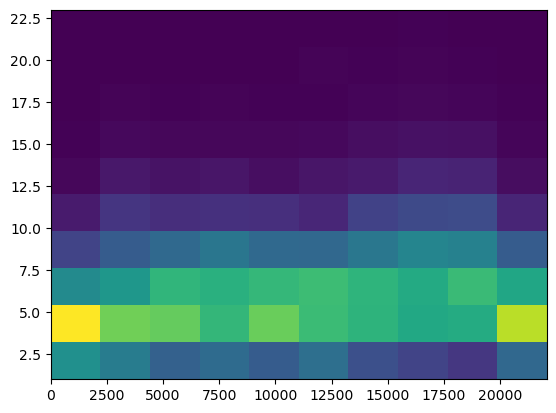

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.74023   0.70643   0.72294      1073
           1    0.76349   0.81857   0.79007      1400
           2    0.69110   0.75000   0.71935       176
           3    0.50000   0.36364   0.42105        11
           4    0.38462   0.09804   0.15625        51
           5    0.48649   0.38710   0.43114        93
           6    0.69149 

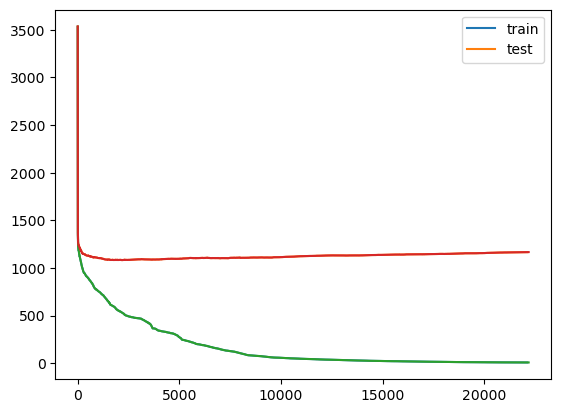

Node: 145820 train sse: 8.544904212334673 test sse: 1167.0642867373306


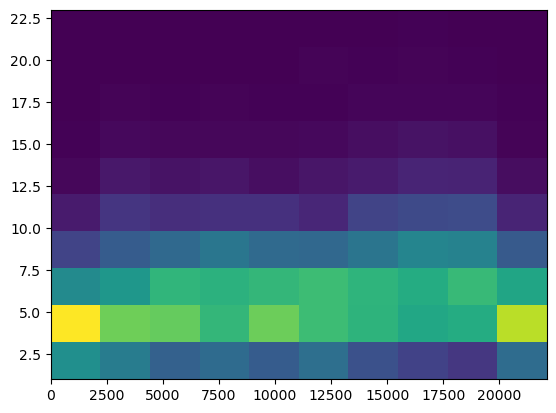

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      1073
           1    1.00000   1.00000   1.00000      1399
           2    1.00000   1.00000   1.00000       176
           3    1.00000   1.00000   1.00000        10
           4    1.00000   1.00000   1.00000        51
           5    1.00000   1.00000   1.00000        94
           6    1.00000   1.00000   1.00000       102

    accuracy                        1.00000      2905
   macro avg    1.00000   1.00000   1.00000      2905
weighted avg    1.00000   1.00000   1.00000      2905

              precision    recall  f1-score   support

           0    0.73854   0.70550   0.72164      1073
           1    0.76318   0.81714   0.78924      1400
           2    0.69110   0.75000   0.71935       176
           3    0.50000   0.36364   0.42105        11
           4    0.38462   0.09804   0.15625        51
           5    0.48649   0.38710   0.43114        93
           6    0.68421 

KeyboardInterrupt: 

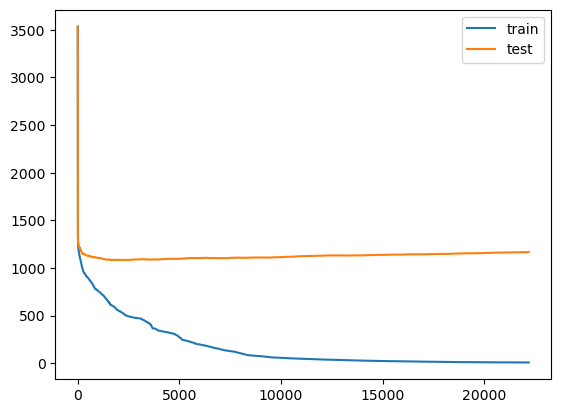

In [40]:
train_acc = []
test_acc = []
train_sse = []
test_sse = []


y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

init_log_odds,init_p = initial(y_train_one_hot)
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)
test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

learning_rate = 0.3
bins = 10
lam = 15
stack = []
losses = []
num_features = X_train.shape[1]

max_depth = 3

total_size = 300
elite_size = 10


stack = []

for _ in range(100):
    batch = []
    loss = []

    eg = Engine(Functions.simple_opset,X_train,y_train,y_train_one_hot,learning_rate,bins,max_depth,lam)
    eg.initialize_nodes(log_odds,p)
    origin_features = eg.nodes.copy()
    origin_losses = eg.losses.copy()
    l = np.sort(origin_losses).astype(np.float64)
    difference = l[1:] - l[:-1]
    difference[difference==0] = 2**16

    tolerance = min(difference) * 10000
    print("torlerance:",tolerance)

    for i in range(256):
        for j in range(4):
            eg.evolve(total_size,elite_size,log_odds,p,tolerance=tolerance,verbose=0)

        prev_len = len(batch)
        winner = eg.nodes
        batch,loss = eg.adding_unique_node(batch,loss,winner,tolerance=tolerance)
        # hit_rate = (len(batch)-prev_len)/len(winner)
        # print("hit rate", hit_rate)

        eg.nodes = origin_features.copy()
        eg.losses = origin_losses.copy()
        # if len(stack) > 8000:
        #         break
        # if hit_rate < 0.001:
        #     break
    print(len(batch),sum([n.numNode for n in batch]),i)

    fits = [i.estimator.loss for i in batch]
    a = [batch[i] for i in np.argsort(fits)]

    for j in range(1):
        score = []
        
        for i,node in enumerate(a):
            node.estimator.lam = lam + 0.1*node.numNode
            grads = node.estimator.set_grads_bin(y_train_one_hot-p,p)
            log_odds,p = update_log_p(grads,log_odds,p,learning_rate)

            test_grads = node.predict_grad(X_test)
            test_log_odds,test_p = update_log_p(test_grads,test_log_odds,test_p,learning_rate)


            train_sse.append(np.sum(np.power(y_train_one_hot - p,2)))
            test_sse.append(np.sum(np.power(y_test_one_hot - test_p,2)))


            # pred = np.argmax(p,axis=1)
            # train_acc.append(accuracy_score(pred,y_train))
            # test_pred = np.argmax(test_p,axis=1)
            # test_acc.append(accuracy_score(test_pred,y_test))
        # plt.plot(train_acc)
        # plt.plot(test_acc)
        # print(train_acc[-1],test_acc[-1],max(test_acc))

        print(train_sse[-1],test_sse[-1],min(test_sse))
    plt.plot(train_sse)
    plt.plot(test_sse)

    plt.legend(["train","test"])
    plt.show()
    print("Node:",sum([n.numNode for n in stack]),"train sse:",train_sse[-1],"test sse:",test_sse[-1])
    plt.hist2d([i for i in range(len(stack))],[n.numNode for n in stack])
    plt.show()
    plt.plot(train_sse)
    plt.plot(test_sse)
    plt.legend(["train","test"])    
    print(classification_report(y_train,np.argmax(p,axis=1),digits=5))
    print(classification_report(y_test,np.argmax(test_p,axis=1),digits=5))
    
    stack.extend(batch)
    losses.extend(loss)

Node: 18437 train sse: 321.3660482091045 test sse: 1066.2990554288926


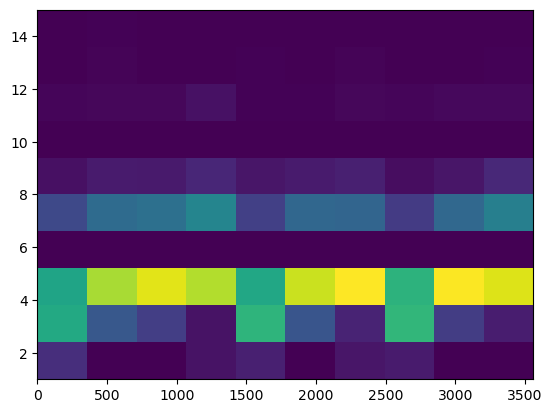

              precision    recall  f1-score   support

           0    0.96110   0.94408   0.95252      1073
           1    0.94521   0.97427   0.95952      1399
           2    0.99425   0.98295   0.98857       176
           3    1.00000   1.00000   1.00000        10
           4    0.97368   0.72549   0.83146        51
           5    1.00000   0.96809   0.98378        94
           6    1.00000   0.94118   0.96970       102

    accuracy                        0.95800      2905
   macro avg    0.98204   0.93372   0.95508      2905
weighted avg    0.95844   0.95800   0.95773      2905

              precision    recall  f1-score   support

           0    0.75397   0.70829   0.73042      1073
           1    0.76444   0.83214   0.79685      1400
           2    0.70745   0.75568   0.73077       176
           3    0.57143   0.36364   0.44444        11
           4    0.33333   0.09804   0.15152        51
           5    0.59420   0.44086   0.50617        93
           6    0.72340 

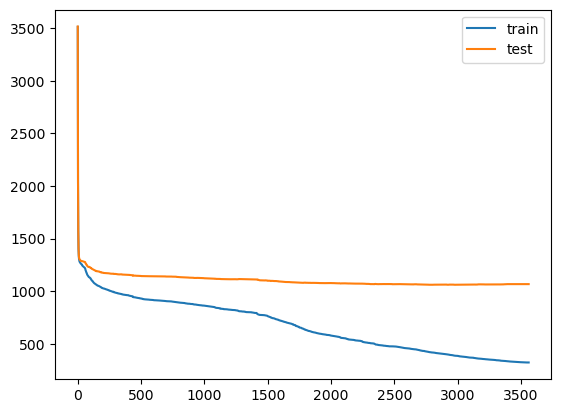

In [15]:
print("Node:",sum([n.numNode for n in stack]),"train sse:",train_sse[-1],"test sse:",test_sse[-1])
plt.hist2d([i for i in range(len(stack))],[n.numNode for n in stack])
plt.show()
plt.plot(train_sse)
plt.plot(test_sse)
plt.legend(["train","test"])    
print(classification_report(y_train,np.argmax(p,axis=1),digits=5))
print(classification_report(y_test,np.argmax(test_p,axis=1),digits=5))